<a href="https://colab.research.google.com/github/ToriShenYixuan/FSL_GBM/blob/main/Proto_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
import os
import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.spatial.distance import cdist
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import time


Mounted at /content/gdrive


In [ ]:
dataset_path = "/content/gdrive/Shareddrives/CompsSharedDrive/data"

exp=1

N_WAY = 3  # Number of classes in a task
N_SHOTs = [3,5,10]  # Number of images per class in the support set
N_TEST = 2 # Number of test selected for each
N_TOTAL =20
N_BOOT = 20
orientations=["axial", "coronal", "saggital"]

sample_ratio = [[[18, 1, 1], [1, 18, 1], [1, 1, 18]],[[14, 3, 3], [3, 14, 3], [3, 3, 14]],[[10, 5, 5], [5, 10, 5], [5, 5, 10]],[[6, 7, 7], [7, 6, 7], [7, 7, 6]]]
t_ratio = [[[10,10],[10,10],[10,10]],[[13,7],[13,7],[13,7]],[[17,3],[17,3],[17,3]]] #sample ratio of t1/t2

# set-up the transformation
transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            ])

In [ ]:

# Initialize global variables and functions

classes=['glioblastoma', 'glioma', 'non-pathological']
class_to_idx={'glioblastoma': 0, 'glioma': 1, 'non-pathological': 2}

# List to store all image file paths
all_images = []

# Walk through the directory structure
for root, dirs, files in os.walk(dataset_path):
    # Check if the folder is named 'images'
    if os.path.basename(root) == 'images':
        # Collect all images in this folder
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                all_images.append(os.path.join(root, file))

# Verify results
print(f"Total 'images' folders found: {len(set(os.path.dirname(img) for img in all_images))}")
print(f"Total images collected: {len(all_images)}")

# Initialize an empty list to hold image information
image_data = []

# Iterate through the collected image paths
for image_path in all_images:
    # Extract the image file name
    image_name = os.path.basename(image_path).lower()

    # Determine the class
    if "glioma" in image_name:
        img_class = "glioma"
    elif "glioblastoma" in image_name:
        img_class = "glioblastoma"
    elif "non-pathological" in image_name or "non-pathelogical" in image_name:
        img_class = "non-pathological"
    else:
        img_class = "unknown"

    # Determine the orientation
    if "axial" in image_name:
        orientation = "axial"
    elif "coronal" in image_name:
        orientation = "coronal"
    elif "saggital" in image_name:
        orientation = "saggital"
    else:
        orientation = "unknown"

    # Determine the imaging type
    if "t1" in image_name:
        imaging = "T1"
    elif "t2" in image_name:
        imaging = "T2"
    else:
        imaging = "unknown"

    # Append the information as a row to the list
    image_data.append({
        "image_path": image_path,
        "class": img_class,
        "orientation": orientation,
        "imaging": imaging,
        "test":0
    })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(image_data)

def sample_test(dataset_df, N_TEST, exp):
    """
    Samples N_TEST images from the dataset based on the specified experiment type.

    Parameters:
    - dataset_df: DataFrame containing image metadata (columns: image_path, class, orientation, imaging)
    - N_TEST: Number of samples to take from each class-condition combination
    - exp: Experiment type (1, 2, or 3)

    Returns:
    - List of tuples, where each tuple contains (image_path, class)
    """
    test_images = []
    dataset_df["test"] = 0

    if exp == 1:
        # Filter for T1 imaging
        filtered_df = dataset_df[dataset_df['imaging'] == 'T1']
        # Group by class and orientation
        grouped = filtered_df.groupby(['class', 'orientation'])

    elif exp == 2:
        N_TEST=3
        # Filter for axial orientation
        filtered_df = dataset_df[dataset_df['orientation'] == 'axial']
        # Group by class and imaging
        grouped = filtered_df.groupby(['class', 'imaging'])

    elif exp == 3:
        # Group by class, orientation, and imaging
        grouped = dataset_df.groupby(['class', 'orientation', 'imaging'])

    else:
        raise ValueError("Invalid experiment type. Choose exp=1, exp=2, or exp=3.")

    # Sample N_TEST images from each group
    for _, group in grouped:
        # Shuffle the group and sample N_TEST rows (or fewer if the group has less than N_TEST)
        sampled = group.sample(n=min(N_TEST, len(group)), random_state=42)
        # Add tuples of (image_path, class) to the sampled list
        test_images.extend(zip(sampled['image_path'], sampled['class']))
        dataset_df.loc[sampled.index, 'test'] = 1

    return test_images


def sample_support_plus_query(dataset_df, orien_ratio, t_ratio, exp, level=None):
    """
    Samples images for support and query based on given orientation, imaging ratios, or levels.

    Parameters:
    - dataset_df: DataFrame containing image metadata (columns: image_path, class, orientation, imaging, test)
    - orien_ratio: List of lists defining sampling ratios for orientations (used in exp=1).
    - t_ratio: List of lists defining sampling ratios for imaging types (used in exp=2).
    - exp: Experiment type (1, 2, or 3).
    - level: Level of sampling for exp=3 (0, 1, 2, or 3).

    Returns:
    - List of tuples, where each tuple contains (image_path, class).
    """
    support_query_images = []

    # Filter for non-test entries
    non_test_df = dataset_df[dataset_df['test'] == 0]

    if exp == 1:
        # Filter for T1 imaging
        filtered_df = non_test_df[non_test_df['imaging'] == 'T1']

        # Assign orientation sampling ratios to classes
        for i, class_name in enumerate(['glioma', 'glioblastoma', 'non-pathological']):
            class_df = filtered_df[filtered_df['class'] == class_name]

            # Sample for each orientation based on orien_ratio[i]
            for j, orientation in enumerate(['axial', 'coronal', 'saggital']):
                orientation_df = class_df[class_df['orientation'] == orientation]
                sampled = orientation_df.sample(
                    n=min(orien_ratio[i][j], len(orientation_df)),
                    random_state=42
                )
                support_query_images.extend(zip(sampled['image_path'], sampled['class']))

    elif exp == 2:
        # Assign imaging sampling ratios to classes
        for i, class_name in enumerate(['glioma', 'glioblastoma', 'non-pathological']):
            class_df = non_test_df[non_test_df['class'] == class_name]

            # Sample for each imaging type based on t_ratio[i]
            for j, imaging in enumerate(['T1', 'T2']):
                imaging_df = class_df[class_df['imaging'] == imaging]
                sampled = imaging_df.sample(
                    n=min(t_ratio[i][j], len(imaging_df)),
                    random_state=42
                )
                support_query_images.extend(zip(sampled['image_path'], sampled['class']))

    elif exp == 3:
        for class_name in ['glioma', 'glioblastoma', 'non-pathological']:
            class_df = non_test_df[non_test_df['class'] == class_name]
            selected_orientation = random.choice(['axial', 'coronal', 'saggital'])

            if level == 0:
                # Randomly select one orientation
                orientation_df = class_df[(class_df['orientation'] == selected_orientation) & (class_df['imaging'] == 'T1')]
                sampled = orientation_df.sample(
                    n=min(20, len(orientation_df)),
                    random_state=42
                )
                support_query_images.extend(zip(sampled['image_path'], sampled['class']))

            elif level == 1:
                # Randomly select one orientation
                for imaging in ['T1', 'T2']:
                    imaging_df = class_df[(class_df['orientation'] == selected_orientation) & (class_df['imaging'] == imaging)]
                    sampled = imaging_df.sample(
                        n=min(10, len(imaging_df)),
                        random_state=42
                    )
                    support_query_images.extend(zip(sampled['image_path'], sampled['class']))

            elif level == 2:
                # Sample 5 from T1 axial, 5 from T2 axial, etc.
                for orientation in ['axial', 'coronal']:
                    for imaging in ['T1', 'T2']:
                        imaging_df = class_df[(class_df['orientation'] == orientation) & (class_df['imaging'] == imaging)]
                        sampled = imaging_df.sample(
                            n=min(5, len(imaging_df)),
                            random_state=42
                        )
                        support_query_images.extend(zip(sampled['image_path'], sampled['class']))

            elif level == 3:
                # Sample 3 from T1 axial, 3 from T2 axial, etc., and 4 from saggital
                for orientation in ['axial', 'coronal']:
                    for imaging in ['T1', 'T2']:
                        imaging_df = class_df[(class_df['orientation'] == orientation) & (class_df['imaging'] == imaging)]
                        sampled = imaging_df.sample(
                            n=min(3, len(imaging_df)),
                            random_state=42
                        )
                        support_query_images.extend(zip(sampled['image_path'], sampled['class']))

                for imaging in ['T1', 'T2']:
                    saggital_df = class_df[(class_df['orientation'] == 'saggital') & (class_df['imaging'] == imaging)]
                    sampled = saggital_df.sample(
                        n=min(4, len(saggital_df)),
                        random_state=42
                    )
                    support_query_images.extend(zip(sampled['image_path'], sampled['class']))

            else:
                raise ValueError("Invalid level for exp=3. Choose level=0, 1, 2, or 3.")
    else:
        raise ValueError("Invalid experiment type. Choose exp=1, exp=2, or exp=3.")
    return support_query_images

def sample_support_query(support_query_images, n_shot, printnum=False):
    """
    For each class, sample `n_shot` images for the support set, and the rest for the query set.

    Args:
    - support_query_images: List of tuples (image_path, class_idx) representing support/query images.
    - n_shot: Number of images to sample for the support set.
    - printnum (bool): If True, print the number of images per class.

    Returns:
    - support_images: List of support images with their class labels.
    - query_images: List of query images with their class labels.
    """
    # Group images by class_idx
    class_to_images = {}
    for img_path, class_idx in support_query_images:
        if class_idx not in class_to_images:
            class_to_images[class_idx] = []
        class_to_images[class_idx].append(img_path)

    support_images = []
    query_images = []

    # Iterate over each class and assign images to support and query sets
    for class_idx, images in class_to_images.items():
        if len(images) < n_shot:
            raise ValueError(f"Not enough images in class {class_idx} to sample {n_shot} support images.")

        # Randomly sample n_shot images for the support set
        support_imgs = random.sample(images, n_shot)
        support_images.extend([(img, class_idx) for img in support_imgs])

        # Set the rest of the images as the query set
        query_imgs = list(set(images) - set(support_imgs))
        query_images.extend([(img, class_idx) for img in query_imgs])

        # Optionally print only the number of support and query images per class
        if printnum:
            print(f"Class {class_idx}: Support = {len(support_imgs)}, Query = {len(query_imgs)}")

    return support_images, query_images

def process_images(image_label_list, transform, class_to_idx):
    images = []
    labels = []
    image_labels = []


    for idx, (img_path, class_label) in enumerate(image_label_list):
        if isinstance(class_label, (tuple, list)):
            class_label = class_label[0]

        # Load and transform the main image
        img = Image.open(img_path).convert('RGB')
        img = transform(img)
        images.append(img)
        labels.append(class_to_idx[class_label])

        # Handle labels if provided; otherwise, use the main image as its label
        label_img_path, _ = image_label_list[idx]

        # Use the main image if `label_img_path` is None or is the image path itself
        if label_img_path is None or label_img_path == img_path:
            label_img = img.clone()  # Use the same image as label
        else:
            label_img = Image.open(label_img_path).convert('RGB')
            label_img = transform(label_img)

        image_labels.append(label_img)

    images = torch.stack(images)
    labels = torch.tensor(labels)
    image_labels = torch.stack(image_labels)
    return images, labels, image_labels

# Define the function to plot images grouped by their labels from tensors
def plot_images_by_label(image_label_list, title):
    """
    Plot a set of images grouped by their labels from image paths.
    Each row corresponds to a different label.

    Args:
    - image_label_list: A list of tuples where each tuple contains:
        (image_path, label)
    - title: Title of the plot.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image

    # Group image paths by label
    images_by_label = {}
    for image_path, label in image_label_list:
        if label not in images_by_label:
            images_by_label[label] = []
        images_by_label[label].append(image_path)

    # Determine the maximum number of images in any row
    max_images_per_row = max(len(images) for images in images_by_label.values())
    num_labels = len(images_by_label)

    # Create a figure to display the images
    fig, axes = plt.subplots(num_labels, max_images_per_row, figsize=(max_images_per_row * 3, num_labels * 3))

    # Adjust axes array for different scenarios
    if num_labels == 1:
        axes = np.array([axes])
    elif max_images_per_row == 1:
        axes = np.array([[ax] for ax in axes])

    # Plot each label's images in a row
    for row_idx, (label, image_paths) in enumerate(images_by_label.items()):
        for col_idx in range(max_images_per_row):
            ax = axes[row_idx, col_idx] if num_labels > 1 else axes[0, col_idx]
            if col_idx < len(image_paths):
                image_path = image_paths[col_idx]
                # Load the image
                img = Image.open(image_path).convert('RGB')
                img = np.array(img)
                img = img / 255.0  # Normalize pixel values

                ax.imshow(img)
                ax.axis('off')

                # Extract orientation and modality from the filename
                filename = image_path.lower()
                orientation = ""
                modality = ""
                if "axial" in filename:
                    orientation = "axial"
                elif "coronal" in filename:
                    orientation = "coronal"
                elif "saggital" in filename:
                    orientation = "saggital"

                if "t1" in filename:
                    modality = "T1"
                elif "t2" in filename:
                    modality = "T2"

                # Set the title including label, orientation, and modality
                ax.set_title(f"Label: {label}\n{orientation} {modality}")
            else:
                ax.axis('off')

    # Set the overall plot title
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Total 'images' folders found: 18
Total images collected: 354


In [ ]:
# Example usage
orien_ratio = [[18, 1, 1], [1, 18, 1], [1, 1, 18]]
t_ratio = [[10, 10], [10, 10], [10, 10]]
exp = 2  # Experiment type
level = 3  # Level for exp=3


# Assuming `df` is your DataFrame created earlier
N_TEST = 2
test_images = sample_test(df, N_TEST, exp)

# Ensure the DataFrame has a 'test' column
if 'test' not in df.columns:
    df['test'] = 0  # Initialize with 0 (non-test)

support_query_images = sample_support_query(df, orien_ratio, t_ratio, exp, level)

print(f"sampleed support len: {len(support_query_images)}")

# Display the sampled data
for item in support_query_images:
    print(item)

print(f"sampleed test len: {len(test_images)}")

# Display the sampled data
for item in test_images:
    print(item)

## Customizations

## Prototypical Model

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone
        self.feature_maps = None  # Placeholder for feature maps

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        # Extract features of support and query images
        z_support = self.backbone(support_images)
        z_query = self.backbone(query_images)
        # Store the feature maps for Grad-CAM
        self.feature_maps = z_query
        # Rest of your forward function...
        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        return scores

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output
    return hook
convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network)

# Register the hook
target_layer = model.backbone.layer4  # Adjust if needed
target_layer.register_forward_hook(get_activation('layer4'))


# convolutional_network = resnet18(pretrained=True)
# convolutional_network.fc = nn.Flatten()
# #print(convolutional_network)

# model = PrototypicalNetworks(convolutional_network)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


## Proto Classification

In [ ]:
def evaluate(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    print_detailed=False
) -> tuple[int, int, torch.Tensor]:
    """
    Evaluates the model and returns the number of correct predictions, total number of predictions,
    and the predicted labels. Optionally prints detailed results.

    Args:
    - support_images: Tensor of support images.
    - support_labels: Tensor of support labels.
    - query_images: Tensor of query images.
    - query_labels: Tensor of query labels.
    - print_detailed: If True, prints ground truth and predicted labels.

    Returns:
    - correct_predictions: Number of correct predictions.
    - total_queries: Total number of queries.
    """
    model.eval()
    with torch.no_grad():
        # Get the model's scores for all query images
        scores = model(support_images, support_labels, query_images)

        # Get the predicted labels from the model's scores
        _, predicted_labels = torch.max(scores.data, 1)

        correct_predictions = (predicted_labels == query_labels).sum().item()
        total_queries = len(query_labels)
        accuracy = correct_predictions / total_queries * 100

        if print_detailed:
            # Reverse the class_to_idx mapping to get idx_to_class
            idx_to_class = {v: k for k, v in class_to_idx.items()}

            # Display the ground truth and predicted labels for all queries
            print("\nDetailed Results:")
            # print("Ground Truth / Predicted")
            for i in range(len(query_labels)):
                gt_label = idx_to_class[query_labels[i].item()]  # Ground truth class name
                pred_label = idx_to_class[predicted_labels[i].item()]  # Predicted class name
                # print(f"{gt_label} / {pred_label}")

                # Display the query image
                img_tensor = query_images[i].cpu()
                img = img_tensor.permute(1, 2, 0).numpy()

                # Plot the image
                plt.figure(figsize=(2, 2))
                plt.imshow(img)
                plt.title(f"Ground Truth: {gt_label} | Predicted: {pred_label}")
                plt.axis('off')
                plt.show()

            # Display the overall accuracy
            print(f"\nAccuracy: {correct_predictions}/{total_queries} = {accuracy:.2f}%")

    return correct_predictions, total_queries

## IMP Classification

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# For deterministic computation in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def create_encoder():
    """Creates a ResNet-18 encoder with a 64-dimensional output."""
    model = resnet18(weights=None)  # Load pretrained ResNet-18
    # Fix the seed before initializing the last layer
    torch.manual_seed(42)
    model.fc = nn.Linear(model.fc.in_features, 64)  # Modify the last layer
    return model

def dp_means_clustering_adaptive(X, initial_lambda, learn_sigma=False):
    cluster_centers = [X[0]]  # Start with the first point as a cluster
    labels = np.zeros(len(X), dtype=int)
    cluster_variances = [1.0]  # Initialize cluster variance

    for i in range(1, len(X)):
        distances = cdist([X[i]], cluster_centers)  # Distance to all clusters
        adjusted_distances = distances / np.sqrt(cluster_variances)
        min_distance = np.min(adjusted_distances)

        # Create new cluster if no cluster is close enough
        if min_distance > initial_lambda:
            cluster_centers.append(X[i])
            cluster_variances.append(1.0 if not learn_sigma else np.var(X[i]))  # Initialize new variance
            labels[i] = len(cluster_centers) - 1
        else:
            labels[i] = np.argmin(adjusted_distances)
            # Optional: Ensure deterministic behavior in case of ties
            # labels[i] = int(np.argmin(adjusted_distances))

    # Optionally learn sigma as the variance of each cluster's points
    if learn_sigma:
        for cluster_idx in range(len(cluster_centers)):
            cluster_points = X[labels == cluster_idx]
            if len(cluster_points) > 1:
                cluster_variances[cluster_idx] = np.var(cluster_points, axis=0).mean()
            else:
                cluster_variances[cluster_idx] = 1.0  # Default variance for single-point clusters

    return np.array(cluster_centers), labels, cluster_variances

def estimate_lambda(alpha=1.0, sigma=1.0, rho=0.1, d=64):
    """Estimate threshold lambda based on Bayesian nonparametric derivations."""
    return 2 * sigma * np.log(alpha / ((1 + (rho / sigma)) ** (d / 2)))

def predict_with_prototypes(X, prototypes, variances):
    proto_centroids = np.array([proto[0] for proto in prototypes])
    proto_labels = [proto[1] for proto in prototypes]

    # Adjust distances based on cluster variance
    distances = cdist(X, proto_centroids) / np.sqrt(variances)
    min_distances = np.argmin(distances, axis=1)

    # Assign the predicted labels
    predictions = [proto_labels[idx] for idx in min_distances]
    return predictions

def IMP_classify(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    print_detailed=False
):
    # Load the pretrained encoder
    encoder = create_encoder()
    encoder.eval()  # Set to evaluation mode

    # Extract embeddings
    with torch.no_grad():
        support_embeddings = encoder(support_images).numpy()
        query_embeddings = encoder(query_images).numpy()

    # Infer prototypes using adaptive DP-means clustering with variance learning
    lambda_threshold = estimate_lambda()
    prototypes = []
    variances = []

    unique_labels = np.unique(support_labels.numpy())
    for label in unique_labels:
        class_embeddings = support_embeddings[support_labels.numpy() == label]
        cluster_centroids, _, cluster_variances = dp_means_clustering_adaptive(
            class_embeddings, lambda_threshold, learn_sigma=True)
        prototypes.extend([(centroid, label) for centroid in cluster_centroids])
        variances.extend(cluster_variances)

    # Predict and visualize results
    y_pred = predict_with_prototypes(query_embeddings, prototypes, variances)
    y_true = query_labels.numpy()
    correct_predictions = (np.array(y_pred) == y_true).sum()
    total_predictions = len(query_labels)
    accuracy = correct_predictions / total_predictions

    if print_detailed:
        plot_predictions(query_images, query_labels, y_pred, idx_to_class, title="Predictions vs. Actual Labels")
        print(classification_report(y_true, y_pred, target_names=classes))
        print(f"Overall Accuracy: {accuracy * 100:.2f}% ({correct_predictions}/{total_predictions})")

    return correct_predictions, total_predictions

def plot_predictions(images_tensor, actual_labels, predicted_labels, idx_to_class, title):
    num_images = len(images_tensor)
    cols = min(5, num_images)  # Max 5 images per row
    rows = (num_images + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for idx, (img_tensor, ax) in enumerate(zip(images_tensor, axes)):
        img = img_tensor.permute(1, 2, 0).numpy()  # Convert to numpy
        img = np.clip(img, 0, 1)  # Clip values

        actual = idx_to_class[actual_labels[idx].item()]
        predicted = idx_to_class[predicted_labels[idx]]

        ax.imshow(img)
        ax.set_title(f"Actual: {actual}\nPred: {predicted}", fontsize=8)
        ax.axis('off')

    for ax in axes[num_images:]:
        ax.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## Optimization and Sampling Algorithms

In [ ]:
def optimize_proto(support_query_images, N_WAY, N_SHOT, N_TOTAL, transform, N_BOOT, print_details=False, plot_support=False):
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Variables for tracking highest accuracy
    acc_proto = 0
    acc_imp = 0
    highest_support_images_tensor_proto = []
    highest_support_labels_proto = []
    highest_support_images_proto=[]
    highest_support_images_tensor_imp = []
    highest_support_labels_imp = []
    highest_support_images_imp=[]


    for i in range(N_BOOT):
        last = (i == 0)

        # Sample support and query sets
        support_images, query_images = sample_support_query(support_query_images, N_SHOT, printnum=False)

        # Process support images and their labels, query images and their labels
        support_images_tensor, support_labels, support_image_labels_tensor = process_images(
            support_images, transform, class_to_idx
        )
        query_images_tensor, query_labels, query_image_labels_tensor = process_images(
            query_images, transform, class_to_idx
        )

        # Call prototypical network to evaluate accuracy on this support sample
        correct, total = evaluate(support_images_tensor, support_labels, query_images_tensor, query_labels)
        new_acc_proto = correct / total

        if new_acc_proto > acc_proto:
            acc_proto = new_acc_proto
            highest_support_images_tensor_proto = support_images_tensor
            highest_support_labels_proto = support_labels
            highest_support_images_proto = support_images

        # Call IMP network to evaluate accuracy on this support sample
        correct, total = IMP_classify(support_images_tensor, support_labels, query_images_tensor, query_labels)
        new_acc_imp = correct / total

        if new_acc_imp > acc_imp:
            acc_imp = new_acc_imp
            highest_support_images_tensor_imp = support_images_tensor
            highest_support_labels_imp = support_labels
            highest_support_images_imp = support_images
        if print_details:
            print(f"bootstrap {i+1} for proto:  {correct}/{total} = {new_acc_proto:.2%}")
            print(f"bootstrap {i+1} for imp:  {correct}/{total} = {new_acc_imp:.2%}")
    if print_details:
        print(f"  Highest Accuracy for imp: {acc_imp:.2%}")
        print(f"  Highest Accuracy for proto: {acc_proto:.2%}")
    if plot_support:
        plot_images_by_label(highest_support_images_proto, "Best Support Images by Label (Prototypical)")
        plot_images_by_label(highest_support_images_imp, "Best Support Images by Label (IMP)")

    # Return the highest-performing support set, plus the test images, support/query sets, and class mappings
    return highest_support_images_tensor_proto, highest_support_labels_proto, highest_support_images_tensor_imp, highest_support_labels_imp

## Test

In [ ]:
dataset_path = "/content/gdrive/Shareddrives/CompsSharedDrive/data"

exp=1

N_WAY = 3  # Number of classes in a task
N_SHOTs = [5]  # Number of images per class in the support set
N_TEST = 2 # Number of test selected for each
N_TOTAL =20
N_BOOT = 20
levels=[0,1,2,3]
orientations=["axial", "coronal", "saggital"]
agg=5 # how many tries to aggregate results over

orien_ratios = [[[18, 1, 1], [1, 18, 1], [1, 1, 18]],[[14, 3, 3], [3, 14, 3], [3, 3, 14]],[[10, 5, 5], [5, 10, 5], [5, 5, 10]],[[6, 7, 7], [7, 6, 7], [7, 7, 6]]]
t_ratios = [[[10,10],[10,10],[10,10]],[[13,7],[13,7],[13,7]],[[17,3],[17,3],[17,3]]] #sample ratio of t1/t2

# set-up the transformation
transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            ])


In [ ]:
def best_rand_all(support_query_images, N_SHOT, agg, orien_ratio, t_ratio, exp, level):
      osp_sum=0
      osi_sum=0
      rsp_sum=0
      rsi_sum=0
      asp_sum=0
      asi_sum=0
      for i in range(agg):
          test_images=sample_test(df, N_TEST, exp)
          start_time = time.time()
          support_query_images = sample_support_plus_query(df, orien_ratio, t_ratio, exp, level)
          highest_tensor_proto, highest_labels_proto, highest_tensor_imp, highest_labels_imp,=optimize_proto(support_query_images, N_WAY, N_SHOT, N_TOTAL, transform, N_BOOT)
          end_time = time.time()
          elapsed_time = end_time - start_time
          print(f"      Elapsed time for optimization: {elapsed_time:.2f} seconds")

          # best
          test_images_tensor, test_labels, _ = process_images(test_images, transform, class_to_idx)
          correct, total = evaluate(highest_tensor_proto, highest_labels_proto, test_images_tensor, test_labels, print_detailed=False)
          osp_sum+=correct/total
          print(f"{correct/total}={osp_sum:.2%}")
          correct, total = IMP_classify(highest_tensor_imp, highest_labels_imp, test_images_tensor, test_labels, print_detailed=False)
          osi_sum+=correct/total
          print(f"{correct/total}={osi_sum:.2%}")

          # random
          num_random=10
          test_images_tensor, test_labels, _ = process_images(test_images, transform, class_to_idx)
          total_acc_proto=0
          total_acc_imp=0
          for i in range(num_random):
              random_support_images, query_images = sample_support_query(support_query_images, 5)
              random_support_images_tensor, random_support_labels, _ = process_images(random_support_images, transform, class_to_idx)
              correct, total = evaluate(random_support_images_tensor, random_support_labels, test_images_tensor, test_labels, print_detailed=False)
              total_acc_proto+=correct/total
              correct, total = IMP_classify(random_support_images_tensor, random_support_labels, test_images_tensor, test_labels, print_detailed=False)
              total_acc_imp+=correct/total
          rsp_sum+=total_acc_proto/num_random
          rsi_sum+=total_acc_imp/num_random
          print(rsp_sum)
          print(rsi_sum)

          # all
          remaining_images_tensor, query_images = sample_support_query(support_query_images, 19)
          all_image_tensor, all_image_label, _ = process_images(remaining_images_tensor, transform, class_to_idx)
          test_images_tensor, test_labels, _ = process_images(test_images, transform, class_to_idx)
          correct, total = evaluate(all_image_tensor, all_image_label, test_images_tensor, test_labels, print_detailed=False)
          print(f"{correct/total}={asp_sum:.2%}")
          asp_sum+=correct/total
          correct, total = IMP_classify(all_image_tensor, all_image_label, test_images_tensor, test_labels, print_detailed=False)
          print(f"{correct/total}={asi_sum:.2%}")
          asi_sum+=correct/total

          end_time = time.time()
          elapsed_time = end_time - start_time
          print(f"      Total time: {elapsed_time:.2f} seconds \n")
      print(f"  Test Results aggregated:")
      print(f"    Optimized support (proto):  {osp_sum/agg:.2%}")
      print(f"    Optimized support (imp):  {osi_sum/agg:.2%}")
      print(f"    Random support (proto):  {rsp_sum/agg:.2%}")
      print(f"    Random support (imp):  {rsi_sum/agg:.2%}")
      print(f"    All as support (proto):  {asp_sum/agg:.2%}")
      print(f"    All as support (imp):  {asi_sum/agg:.2%}")
      print("\n \n")


def test(exp):
    for N_SHOT in N_SHOTs:
      print(f"\nStarting test on Experiment {exp}:\n  Shot size: {N_SHOT}")
      if exp==1:
          for orien_ratio in orien_ratios:
              print(f"  Skewness: {orien_ratio[0]} \n")
              best_rand_all(support_query_images, N_SHOT, agg, orien_ratio, True, exp, True)
      if exp==2:
          for t_ratio in t_ratios:
              print(f"  Single Noise ratio: {t_ratio[0]} \n")
              best_rand_all(support_query_images, N_SHOT, agg, True, t_ratio, exp, True)
      if exp==3:
          for level in levels:
              print(f"  Noise Mixture level: {level} \n")
              best_rand_all(support_query_images, N_SHOT, agg, True, True, exp, level)



In [ ]:
test(1)


Starting test on Experiment 1:
  Shot size: 5
  Skewness: [18, 1, 1] 

      Elapsed time for optimization: 39.68 seconds
0.5
0.7777777777777778
0.49444444444444446
0.7333333333333334
0.5555555555555556
0.8888888888888888
      Total time: 62.04 seconds 

      Elapsed time for optimization: 41.05 seconds
1.1111111111111112
1.3333333333333335
1.011111111111111
1.4000000000000001
1.1111111111111112
1.7777777777777777
      Total time: 54.97 seconds 

      Elapsed time for optimization: 39.58 seconds
1.6111111111111112
2.111111111111111
1.5444444444444445
2.1055555555555556
1.6666666666666667
2.611111111111111
      Total time: 53.97 seconds 

      Elapsed time for optimization: 40.42 seconds
2.0555555555555554
2.9444444444444446
2.1
2.8
2.2222222222222223
3.5
      Total time: 54.52 seconds 

      Elapsed time for optimization: 39.26 seconds
2.6111111111111107
3.666666666666667
2.5722222222222224
3.522222222222222
2.7777777777777777
4.388888888888889
      Total time: 53.18 seconds 

## Graphs of Test Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the CSV data into pandas DataFrame
# Replace 'path/to/data.csv' with your actual file path
df = pd.read_csv('/content/gdrive/Shareddrives/CompsSharedDrive/results/exp2.csv')


In [ ]:
df

,Sequence_Ratio,n_shot,optimized_proto,optimized_imp,random_proto,random_imp,all_proto,all_imp
0,18/2,3,58.33,58.33,39.17,48.00,58.33,71.67
1,18/2,5,65.00,65.00,43.17,55.33,58.33,71.67
2,18/2,10,61.67,61.67,53.67,50.50,58.33,71.67
3,14/6,3,61.67,63.33,38.50,61.17,58.33,71.67
4,14/6,5,65.00,65.00,54.67,62.83,58.33,71.67
5,14/6,10,68.33,68.33,53.67,62.00,58.33,71.67
6,10/10,3,58.33,63.33,63.13,62.50,58.33,71.67
7,10/10,5,70.00,75.00,63.17,66.17,58.33,71.67
8,10/10,10,83.33,75.00,65.83,68.67,58.33,71.67


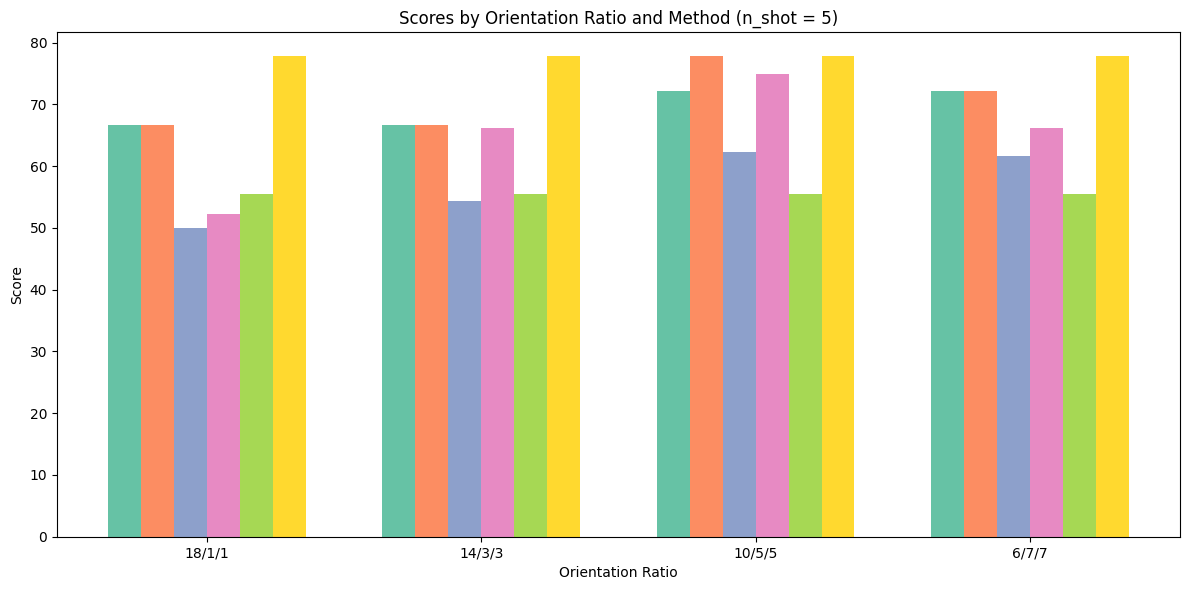

In [ ]:
from matplotlib import cm

# Step 2: Filter the DataFrame to include only rows where n_shot is 5
df_filtered = df[df['n_shot'] == 5]

# Step 3: Prepare data for plotting
methods = ['optimized_proto', 'optimized_imp', 'random_proto',
           'random_imp', 'all_proto', 'all_imp']

# Set orientation_ratio as index
df_pivot = df_filtered.set_index('Orientation_Ratio')[methods]

# Get unique orientation_ratios and methods
orientation_ratios = df_pivot.index.tolist()
n_groups = len(orientation_ratios)
n_methods = len(methods)

# Plot settings
bar_width = 0.12
index = np.arange(n_groups)
adjustments = np.arange(n_methods) * bar_width - (n_methods / 2) * bar_width + bar_width / 2

# Choose a qualitative color scale and create color mappings for each method
colormap = plt.colormaps['Set2']  # or any other qualitative colormap like 'Set1'
colors = [colormap(i) for i in range(n_methods)]  # Generate distinct colors

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each method with colors from the colormap
for i, method in enumerate(methods):
    scores = df_pivot[method].values
    positions = index + adjustments[i]
    ax.bar(positions, scores, width=bar_width, label=method, color=colors[i])

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(orientation_ratios)

# Labeling the axes and adding title
ax.set_xlabel('Orientation Ratio')
ax.set_ylabel('Score')
ax.set_title('Scores by Orientation Ratio and Method (n_shot = 5)')

# Add legend
# ax.legend()

# Display the plot
plt.tight_layout()
plt.show()



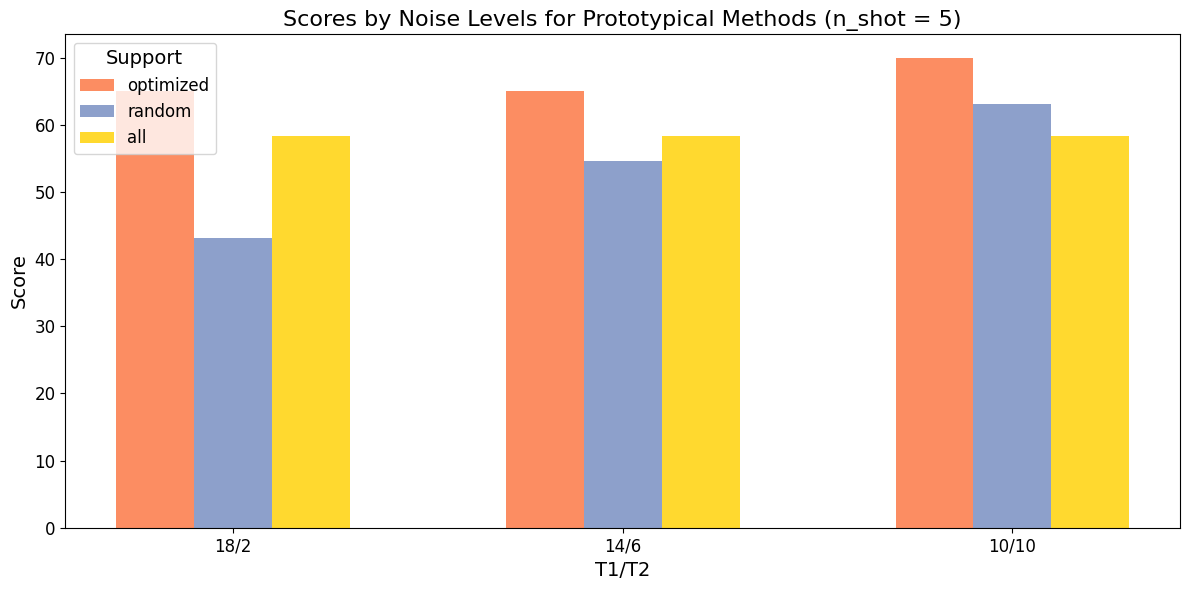

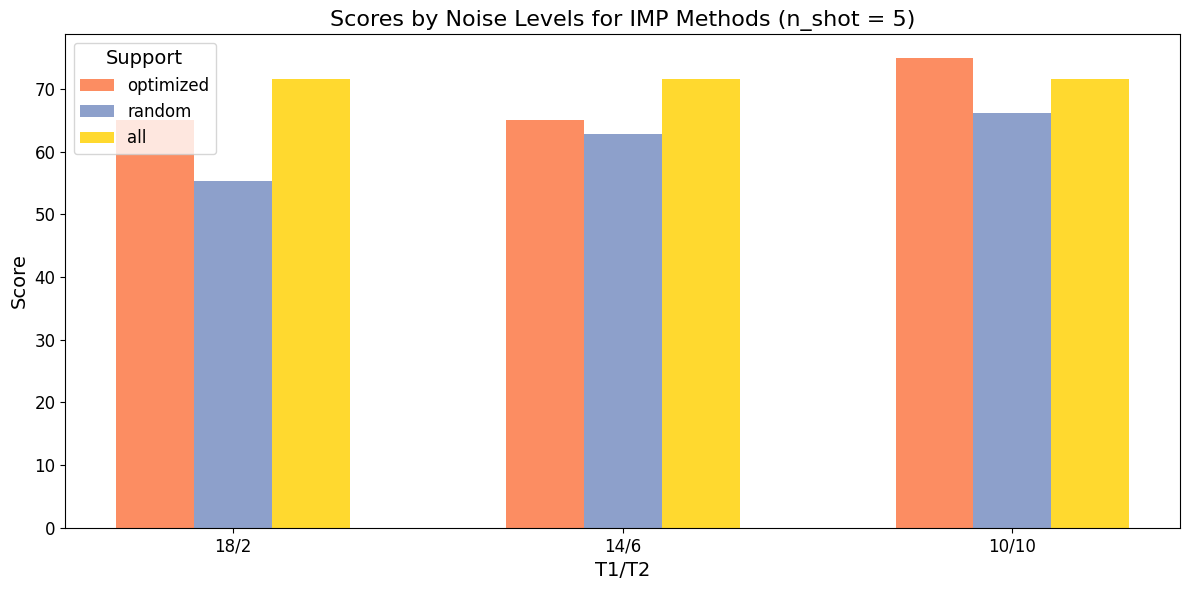

In [ ]:
# Filter the DataFrame to include only rows where n_shot is 5
df_filtered = df[df['n_shot'] == 5]

# Define method groups
proto_methods = ['optimized_proto', 'random_proto', 'all_proto']
imp_methods = ['optimized_imp', 'random_imp', 'all_imp']
legend_labels = ['optimized', 'random', 'all']

# Plot settings
bar_width = 0.2  # Slightly wider bars for clarity in separate plots
index = np.arange(len(df_filtered['Sequence_Ratio'].unique()))

# Plot 1: Proto Methods
fig, ax = plt.subplots(figsize=(12, 6))

# Choose a color scale for proto methods
colormap = plt.colormaps['Set2']
selected_colors = [colormap.colors[i] for i in [1, 2, 5]]
colors_proto = [colormap(i) for i in range(len(proto_methods))]

# Plot bars for each proto method
for i, (method, label) in enumerate(zip(proto_methods, legend_labels)):
    scores = df_filtered[method].values
    positions = index + i * bar_width - (len(proto_methods) / 2) * bar_width + bar_width / 2
    ax.bar(positions, scores, width=bar_width, label=label, color=selected_colors[i])

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(df_filtered['Sequence_Ratio'].unique(), fontsize=12)

# Labeling the axes and adding title
ax.set_xlabel('T1/T2', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Scores by Noise Levels for Prototypical Methods (n_shot = 5)', fontsize=16)

# Increase the font size for the tick labels
ax.tick_params(axis='both', labelsize=12)

# Add legend with increased font size
ax.legend(title="Support", title_fontsize=14, fontsize=12)

# Display the plot for proto methods
plt.tight_layout()
plt.show()

# Plot 2: Imp Methods
fig, ax = plt.subplots(figsize=(12, 6))

# Choose a color scale for imp methods
colors_imp = [colormap(i) for i in range(len(imp_methods))]

# Plot bars for each imp method
for i, (method, label) in enumerate(zip(imp_methods, legend_labels)):
    scores = df_filtered[method].values
    positions = index + i * bar_width - (len(imp_methods) / 2) * bar_width + bar_width / 2
    ax.bar(positions, scores, width=bar_width, label=label, color=selected_colors[i])

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(df_filtered['Sequence_Ratio'].unique(), fontsize=12)

# Labeling the axes and adding title
ax.set_xlabel('T1/T2', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Scores by Noise Levels for IMP Methods (n_shot = 5)', fontsize=16)

# Increase the font size for the tick labels
ax.tick_params(axis='both', labelsize=12)

# Add legend with increased font size
ax.legend(title="Support", title_fontsize=14, fontsize=12)

# Display the plot for imp methods
plt.tight_layout()
plt.show()


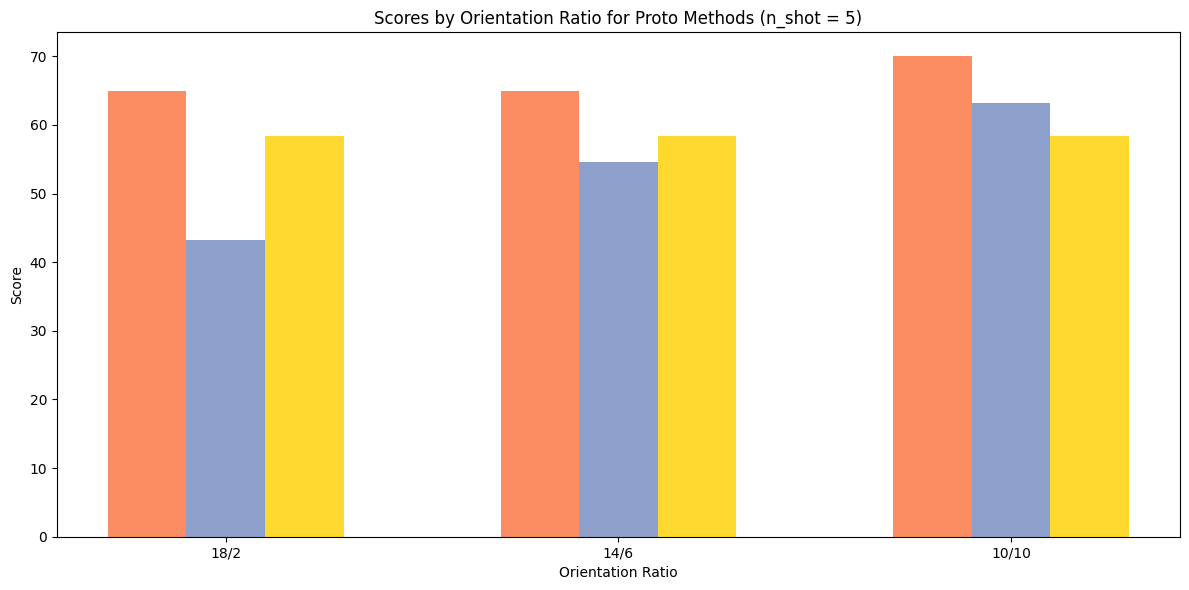

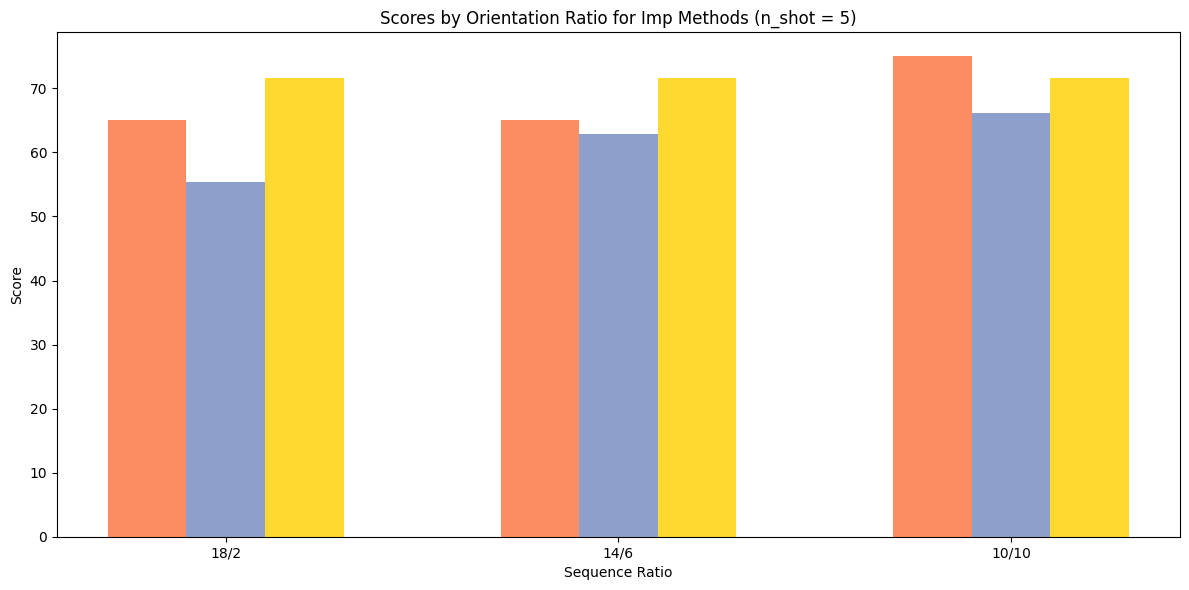

In [ ]:
# Filter the DataFrame to include only rows where n_shot is 5
df_filtered = df[df['n_shot'] == 5]

# Define method groups
proto_methods = ['optimized_proto', 'random_proto', 'all_proto']
imp_methods = ['optimized_imp', 'random_imp', 'all_imp']
legend_labels = ['optimized', 'random', 'all']

# Plot settings
bar_width = 0.2  # Slightly wider bars for clarity in separate plots
index = np.arange(len(df_filtered['Sequence_Ratio'].unique()))

# Plot 1: Proto Methods
fig, ax = plt.subplots(figsize=(12, 6))

# Choose a color scale for proto methods
colormap = plt.colormaps['Set2']
selected_colors = [colormap.colors[i] for i in [1, 2, 5]]
colors_proto = [colormap(i) for i in range(len(proto_methods))]

# Plot bars for each proto method
for i, (method, label) in enumerate(zip(proto_methods, legend_labels)):
    scores = df_filtered[method].values
    positions = index + i * bar_width - (len(proto_methods) / 2) * bar_width + bar_width / 2
    ax.bar(positions, scores, width=bar_width, label=label, color=selected_colors[i])

# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(df_filtered['Sequence_Ratio'].unique())

# Labeling the axes and adding title
ax.set_xlabel('Orientation Ratio')
ax.set_ylabel('Score')
ax.set_title('Scores by Orientation Ratio for Proto Methods (n_shot = 5)')

# Add legend
# ax.legend(title="Support")

# Display the plot for proto methods
plt.tight_layout()
plt.show()

# Plot 2: Imp Methods
fig, ax = plt.subplots(figsize=(12, 6))

# Choose a color scale for imp methods
colors_imp = [colormap(i) for i in range(len(imp_methods))]

# Plot bars for each imp method
for i, (method, label) in enumerate(zip(imp_methods, legend_labels)):
    scores = df_filtered[method].values
    positions = index + i * bar_width - (len(imp_methods) / 2) * bar_width + bar_width / 2
    ax.bar(positions, scores, width=bar_width, label=label, color=selected_colors[i])


# Set x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(df_filtered['Sequence_Ratio'].unique())

# Labeling the axes and adding title
ax.set_xlabel('Sequence Ratio')
ax.set_ylabel('Score')
ax.set_title('Scores by Orientation Ratio for Imp Methods (n_shot = 5)')

# Add legend
# ax.legend(title="Support")

# Display the plot for imp methods
plt.tight_layout()
plt.show()


## Interpretation Visualizations

In [ ]:
!pip install captum

In [ ]:
from captum.attr import LayerGradCam, LayerAttribution, Saliency, IntegratedGradients
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def forward_fn(input_image, support_images, support_labels):
    # Forward pass through the model
    scores = model(support_images, support_labels, input_image)
    # We need to return the scores for attribution
    return scores

In [ ]:
#@title Eval new
def evaluate_new(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    print_detailed=False
) -> tuple[int, int]:
    model.eval()
    # Get the model's scores for all query images
    scores = model(support_images, support_labels, query_images)

    # Get the predicted labels from the model's scores
    _, predicted_labels = torch.max(scores.data, 1)

    correct_predictions = (predicted_labels == query_labels).sum().item()
    total_queries = len(query_labels)
    accuracy = correct_predictions / total_queries * 100

    if print_detailed:
        idx_to_class = {v: k for k, v in class_to_idx.items()}
        # Initialize LayerGradCam
        layer_gc = LayerGradCam(forward_fn, target_layer)

        for i in range(len(query_labels)):
            gt_label = idx_to_class[query_labels[i].item()]
            pred_label = idx_to_class[predicted_labels[i].item()]
            query_image = query_images[i:i+1].clone()
            query_image.requires_grad_()

            # Compute the attribution using LayerGradCam
            attributions = layer_gc.attribute(
                query_image,
                target=predicted_labels[i].item(),
                additional_forward_args=(support_images, support_labels)
            )

            # Upsample attributions to the input image size
            upsampled_attr = LayerAttribution.interpolate(
                attributions, query_image.shape[2:], interpolate_mode='bilinear'
            )

            # Normalize the attributions
            attribution = upsampled_attr.squeeze().cpu().detach().numpy()
            attribution = np.maximum(attribution, 0)
            attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)

            # Apply colormap
            heatmap = plt.get_cmap('jet')(attribution)[:, :, :3]
            heatmap = np.float32(heatmap)

            # Convert the original image to numpy
            img_tensor = query_images[i].cpu()
            img = img_tensor.permute(1, 2, 0).numpy()
            img = np.float32(img)
            img = img / img.max()

            # Overlay the heatmap on the image
            overlayed_img = heatmap * 0.4 + img * 0.6
            overlayed_img = overlayed_img / overlayed_img.max()

            # Plot the image and attribution
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            axes[0].imshow(img)
            axes[0].set_title(f"Image\nGT: {gt_label}\nPred: {pred_label}")
            axes[0].axis('off')

            axes[1].imshow(overlayed_img)
            axes[1].set_title("Grad-CAM")
            axes[1].axis('off')
            plt.show()

        print(f"\nAccuracy: {correct_predictions}/{total_queries} = {accuracy:.2f}%")

    return correct_predictions, total_queries

In [ ]:
#@title Visualize_Saliency
from captum.attr import Saliency

def visualize_saliency(support_images, support_labels, query_images, query_labels):
    saliency = Saliency(forward_fn)
    for i in range(len(query_images)):
        query_image = query_images[i:i+1].clone()
        query_image.requires_grad_()

        # Compute saliency map
        attributions = saliency.attribute(
            query_image,
            target=predicted_labels[i].item(),
            additional_forward_args=(support_images, support_labels)
        )

        # Visualize the saliency map
        attribution = attributions.squeeze().cpu().detach().numpy()
        attribution = np.abs(attribution).max(axis=0)
        attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)

        img_tensor = query_images[i].cpu()
        img = img_tensor.permute(1, 2, 0).numpy()
        img = np.float32(img)
        img = img / img.max()

        # Overlay the saliency map on the image
        heatmap = plt.get_cmap('hot')(attribution)[:, :, :3]
        overlayed_img = heatmap * 0.5 + img * 0.5
        overlayed_img = overlayed_img / overlayed_img.max()

        # Plot the image and saliency map
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(overlayed_img)
        plt.title("Saliency Map")
        plt.axis('off')
        plt.show()


Detailed Results:


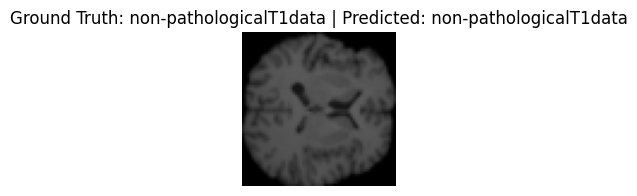

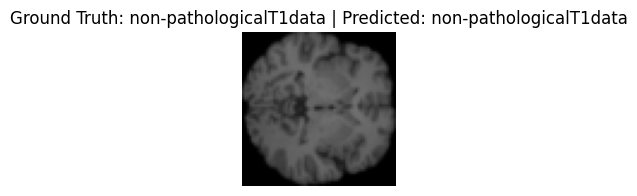

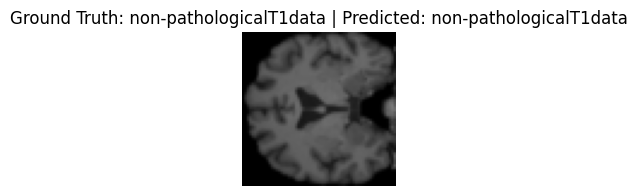

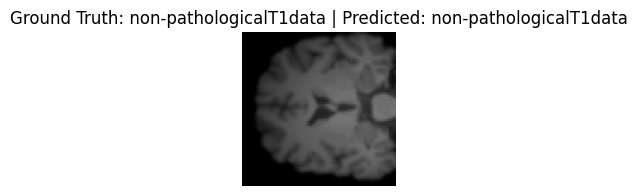

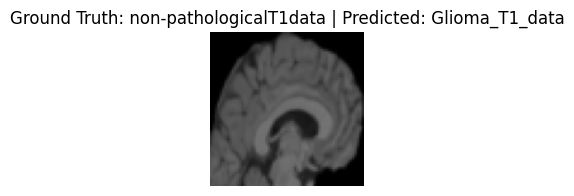

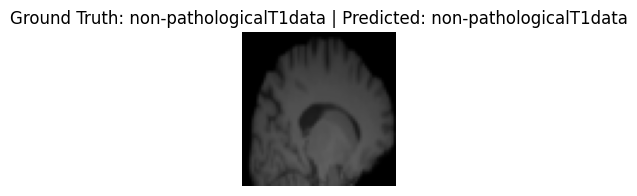

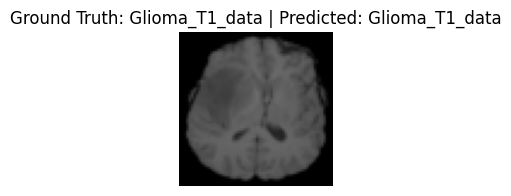

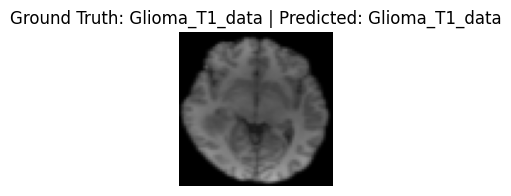

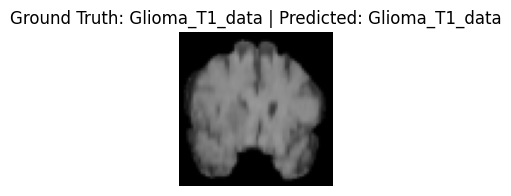

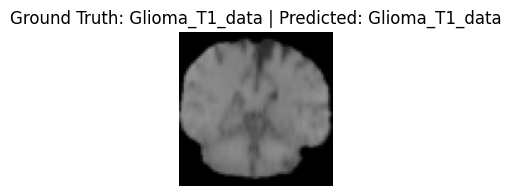

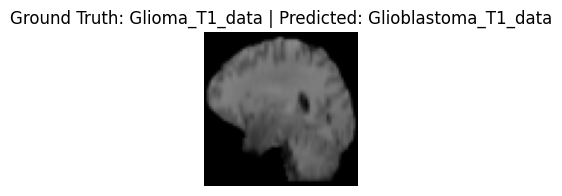

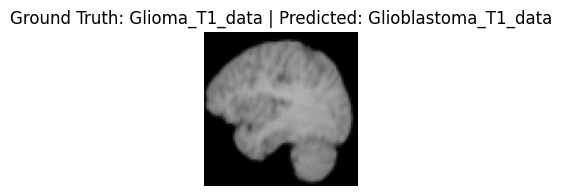

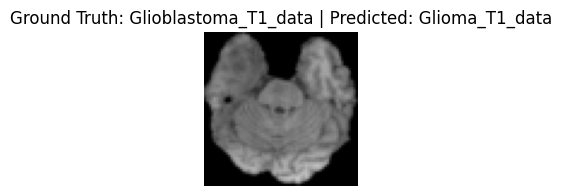

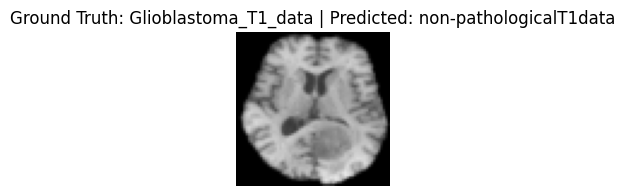

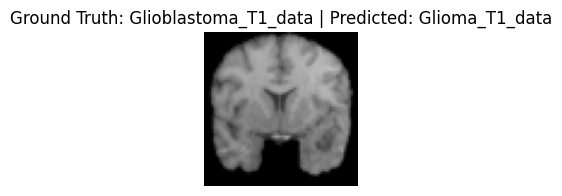

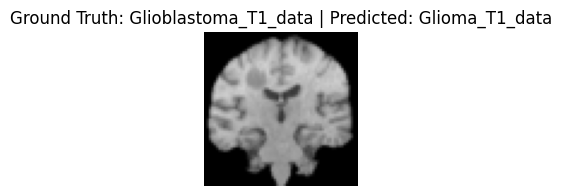

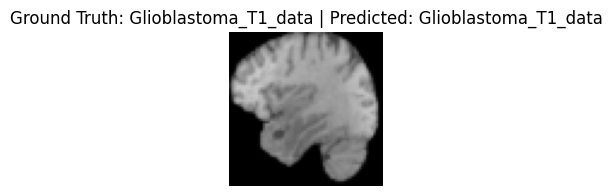

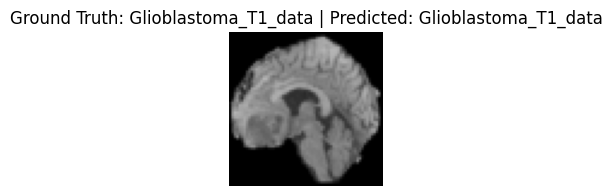


Accuracy: 11/18 = 61.11%
test performance for best:  11/18 =61.11%


In [ ]:
# best
test_images_tensor, test_labels = process_images(test_images, transform, class_to_idx)
# Process test images and their corresponding labels
correct, total = evaluate(highest_support_images_tensor, highest_support_labels, test_images_tensor, test_labels, print_detailed=True)
print(f"test performance for best:  {correct}/{total} ={correct/total:.2%}")

In [ ]:
print("Unique highest support labels:", torch.unique(highest_support_labels))
print("Unique test labels:", torch.unique(test_labels_tensor))
print("Combined unique labels:", torch.unique(torch.cat([highest_support_labels, test_labels_tensor])))

Unique highest support labels: tensor([0, 1, 2])
Unique test labels: tensor([0, 1])
Combined unique labels: tensor([0, 1, 2])


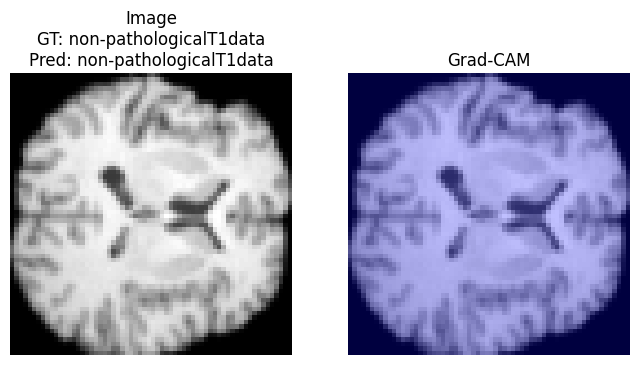

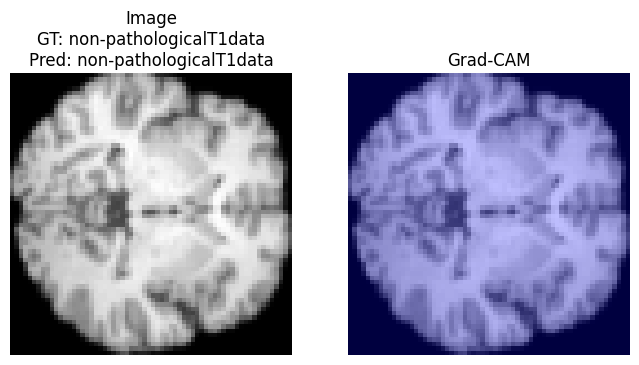

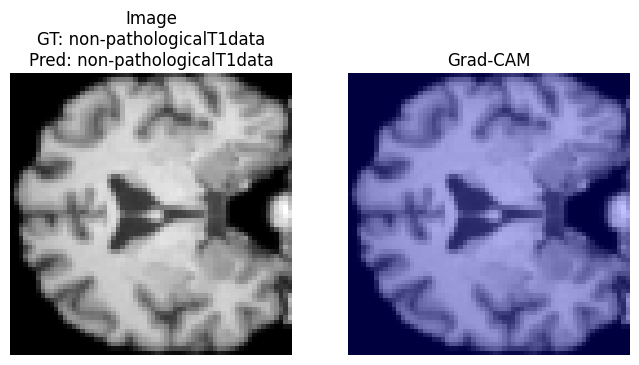

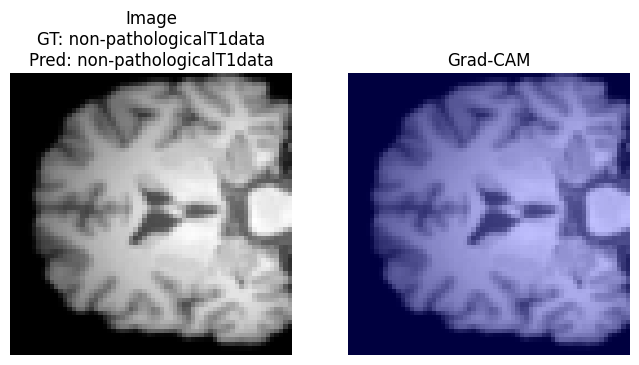

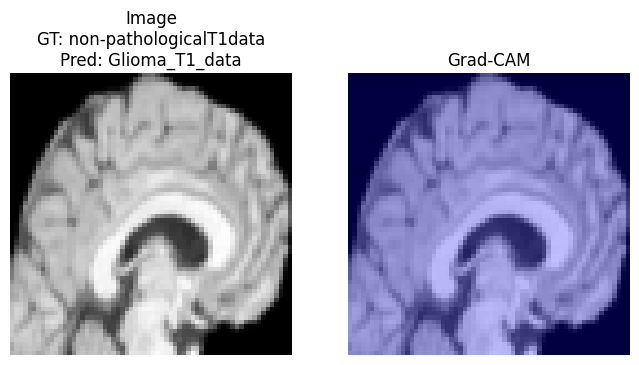

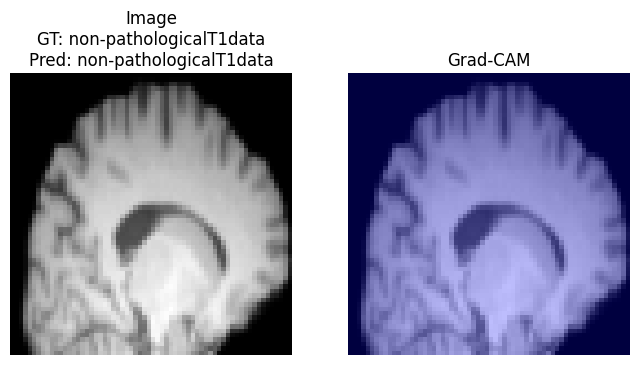

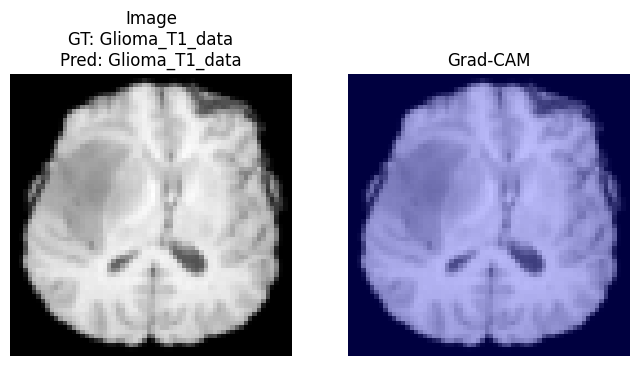

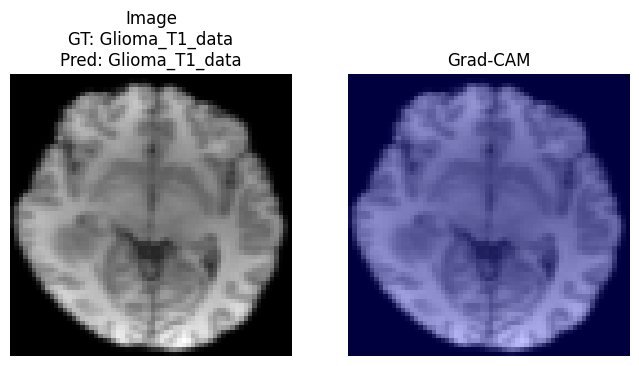

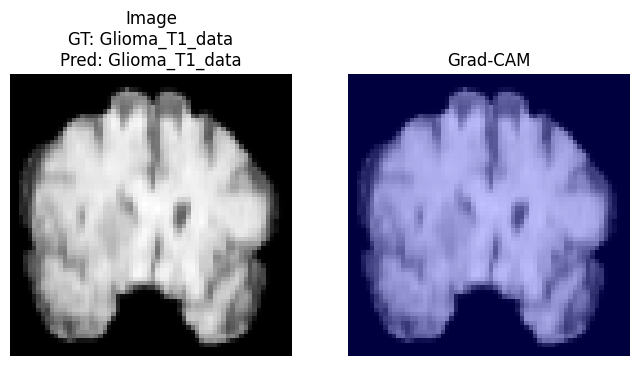

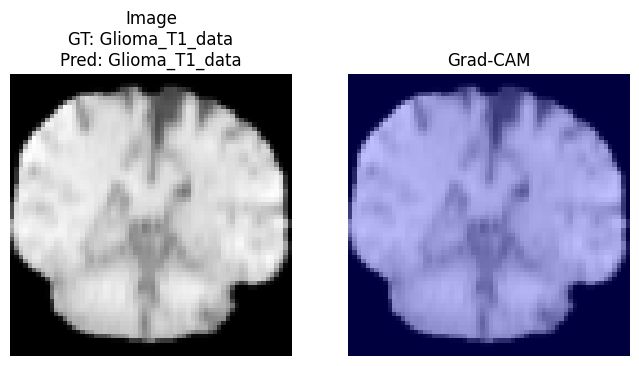

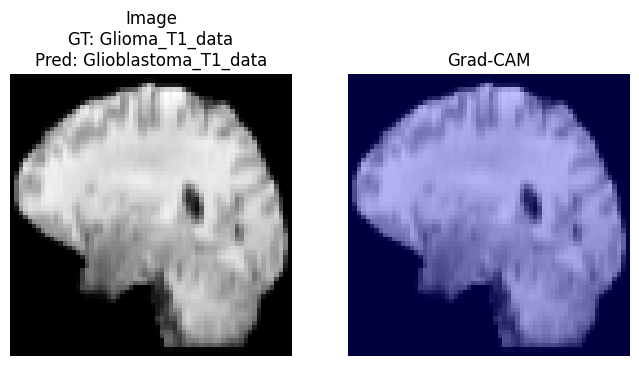

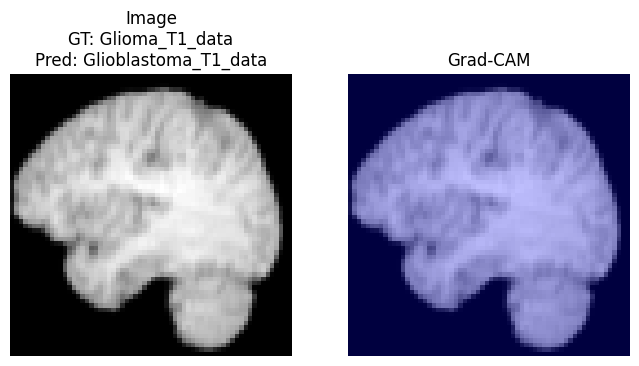

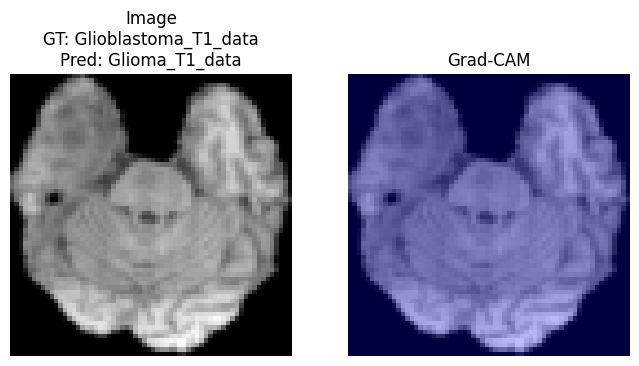

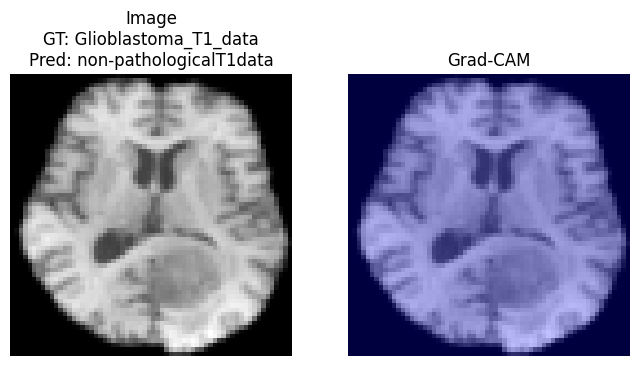

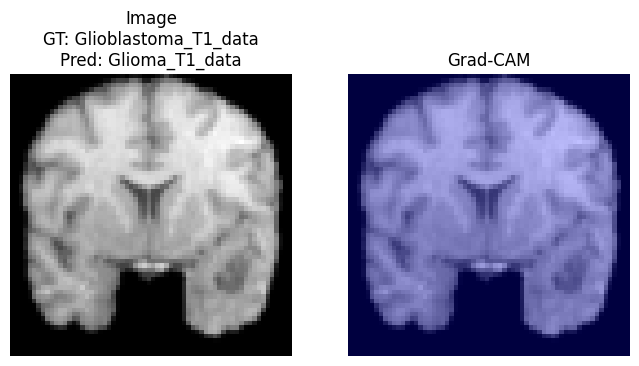

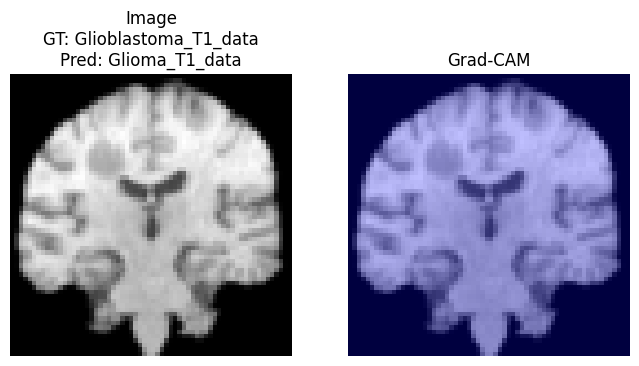

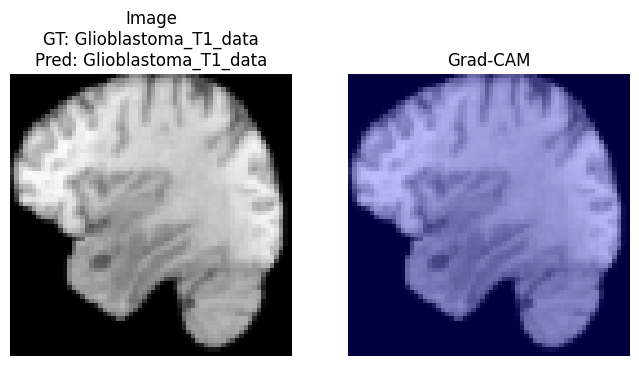

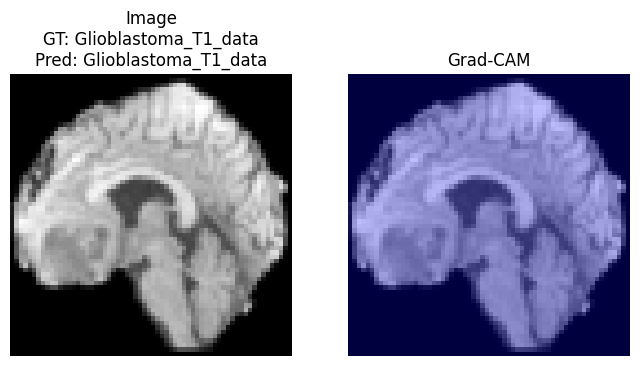


Accuracy: 11/18 = 61.11%
Test performance for best: 11/18 = 61.11%


In [ ]:
# Best
test_images_tensor, test_labels = process_images(test_images, transform, class_to_idx)
correct, total = evaluate_new(
    highest_support_images_tensor,
    highest_support_labels,
    test_images_tensor,
    test_labels,
    print_detailed=True
)
print(f"Test performance for best: {correct}/{total} = {correct/total:.2%}")

In [ ]:
from sklearn.manifold import TSNE

def visualize_embeddings(support_images, support_labels, query_images, query_labels, model):
    # Combine support and query images and labels
    images = torch.cat([support_images, query_images])
    labels = torch.cat([support_labels, query_labels])

    # Get embeddings
    with torch.no_grad():
        embeddings = model.backbone(images).cpu().numpy()

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, perplexity=5, n_iter=3000, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(12, 8))
    num_support = len(support_images)
    plt.scatter(embeddings_2d[:num_support, 0], embeddings_2d[:num_support, 1],
                c=support_labels.cpu(), marker='o', label='Support', cmap='jet')
    plt.scatter(embeddings_2d[num_support:, 0], embeddings_2d[num_support:, 1],
                c=query_labels.cpu(), marker='x', label='Query', cmap='jet')
    plt.legend()
    plt.title('t-SNE visualization of embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

In [ ]:
test_images_tensor, test_labels = process_images(test_images, transform, class_to_idx)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


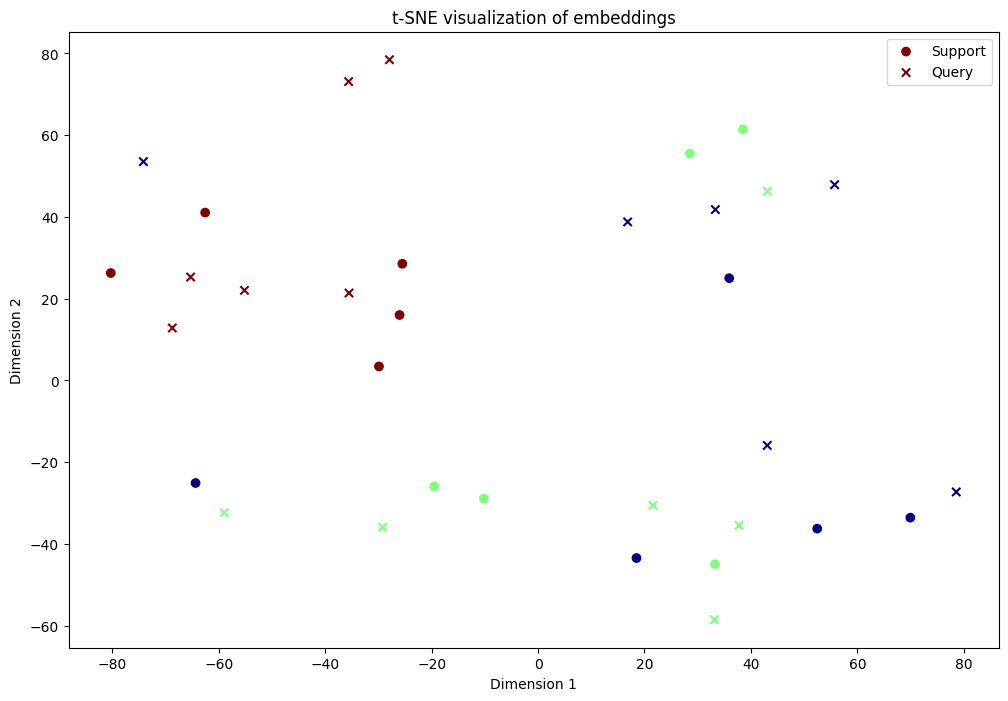

In [ ]:
visualize_embeddings(
    highest_support_images_tensor,
    highest_support_labels,
    test_images_tensor,
    test_labels,
    model
)

In [ ]:
def visualize_saliency(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    model,
    query_image_labels: torch.Tensor  # New parameter for image labels
):
    model.eval()
    saliency = Saliency(forward_fn)
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    scores = model(support_images, support_labels, query_images)
    _, predicted_labels = torch.max(scores.data, 1)

    for i in range(len(query_labels)):
        query_image = query_images[i:i+1].clone()
        query_image.requires_grad_()
        gt_label = idx_to_class[query_labels[i].item()]
        pred_label = idx_to_class[predicted_labels[i].item()]

        # Compute saliency map
        attributions = saliency.attribute(
            query_image,
            target=predicted_labels[i].item(),
            additional_forward_args=(support_images, support_labels)
        )

        attribution = attributions.squeeze().cpu().detach().numpy()
        attribution = np.abs(attribution).max(axis=0)
        attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)

        img_tensor = query_images[i].cpu()
        img = img_tensor.permute(1, 2, 0).numpy()
        img = np.float32(img) / img.max()

        label_img_tensor = query_image_labels[i].cpu()
        label_img = label_img_tensor.permute(1, 2, 0).numpy()
        label_img = np.float32(label_img) / label_img.max()

        heatmap = plt.get_cmap('hot')(attribution)[:, :, :3]
        overlayed_img = heatmap * 0.5 + img * 0.5
        overlayed_img = overlayed_img / overlayed_img.max()

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(img)
        axes[0].set_title(f"Image\nGT: {gt_label}\nPred: {pred_label}")
        axes[0].axis('off')

        axes[1].imshow(overlayed_img)
        axes[1].set_title("Saliency Map")
        axes[1].axis('off')

        axes[2].imshow(label_img)
        axes[2].set_title("Image Label")
        axes[2].axis('off')

        plt.show()

In [ ]:
# Define a function to load images from a list of paths and convert them to tensors
def load_image_tensors(image_paths, transform):
    """
    Load and transform images from a list of paths into a tensor.

    Args:
    - image_paths (list of str): Paths to the images.
    - transform (function): Transform function to apply to each image.

    Returns:
    - torch.Tensor: Stack of image tensors.
    """
    images = []
    for img_path, _ in image_paths:
        if img_path is not None:
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            images.append(img)
        else:
            print(f"Warning: None found in image paths, skipping.")

    if images:
        return torch.stack(images)
    else:
        return torch.empty(0)  # Return an empty tensor if no images were processed


In [ ]:
print(type(test_labels))           # Should print <class 'list'>
print(test_labels[:5])             # Preview the first few entries

<class 'torch.Tensor'>
tensor([2, 2, 2, 2, 2])


In [ ]:
test_image_labels_tensor = load_image_tensors(test_labels, transform)

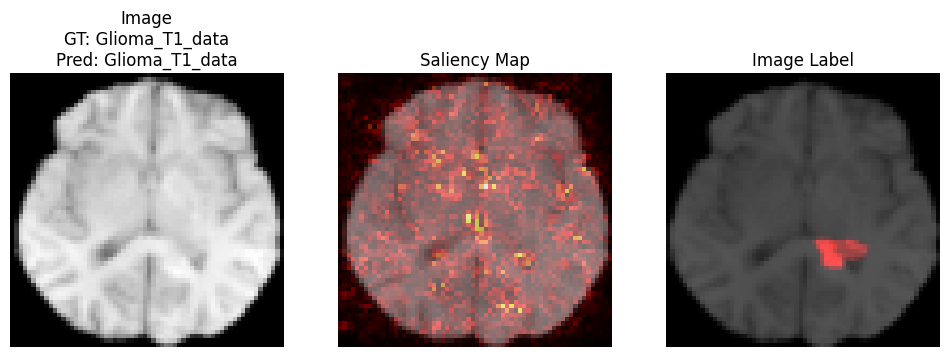

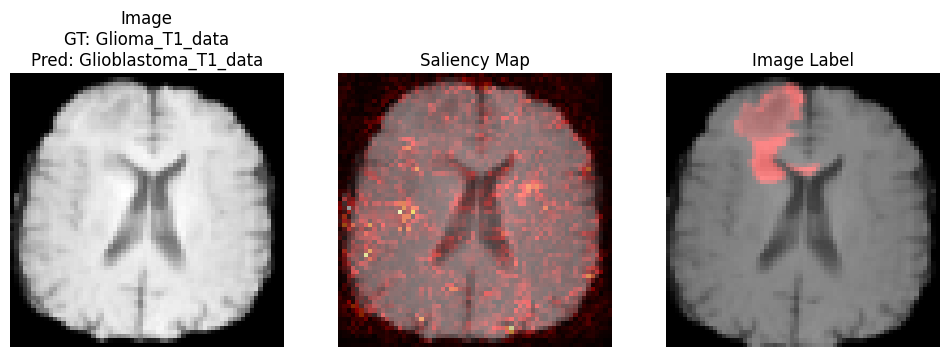

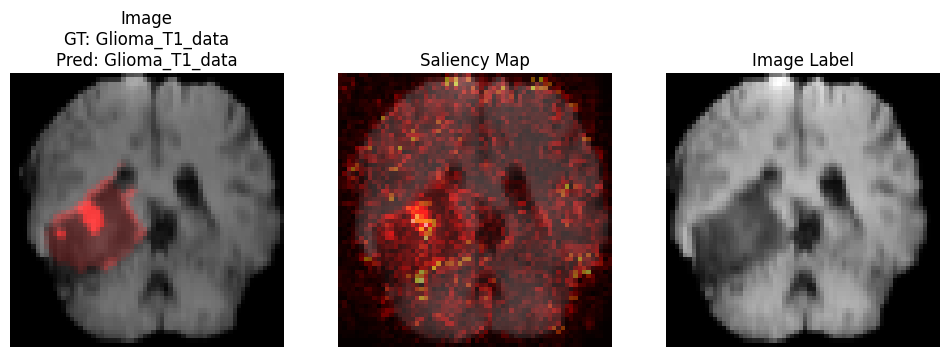

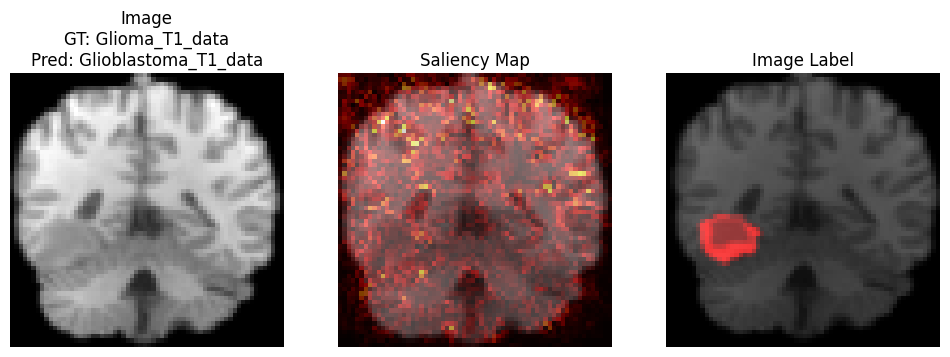

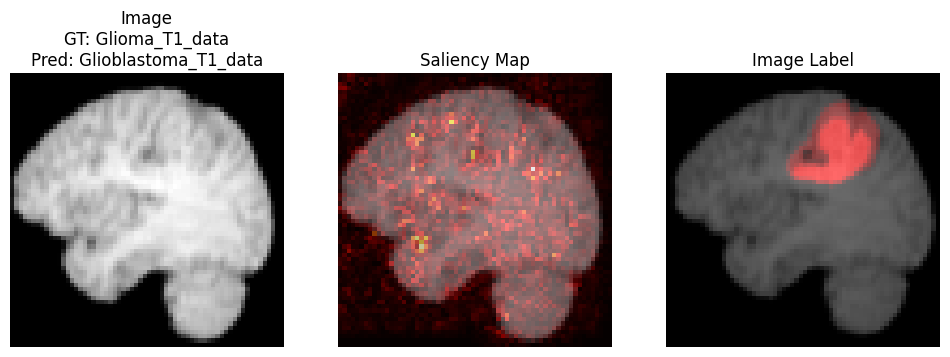

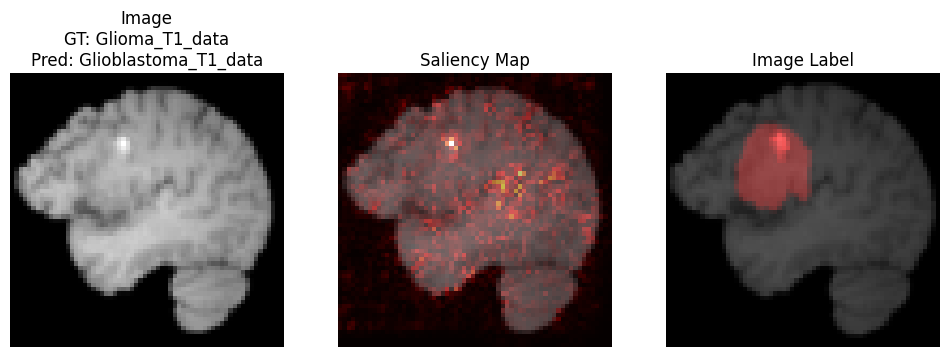

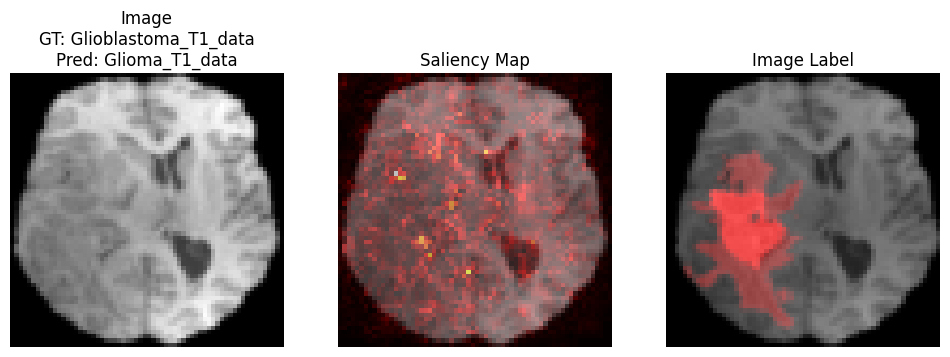

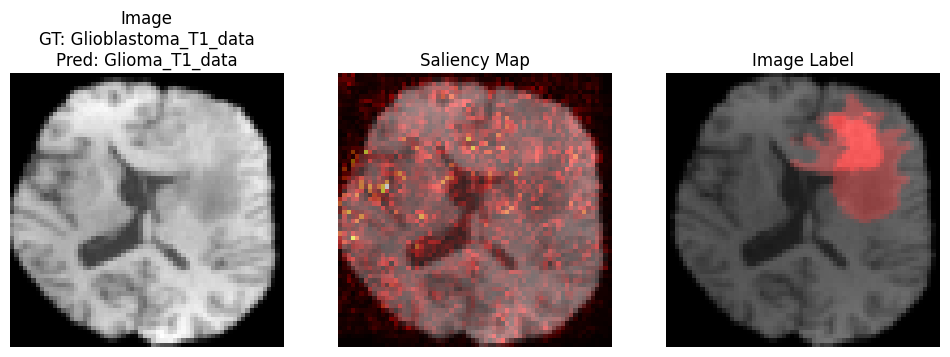

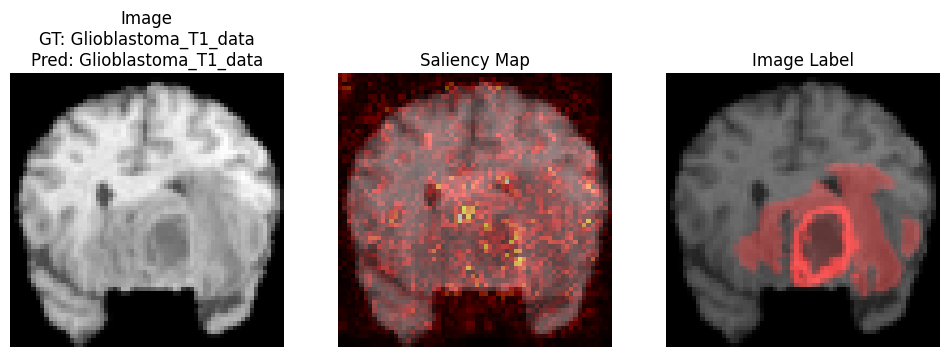

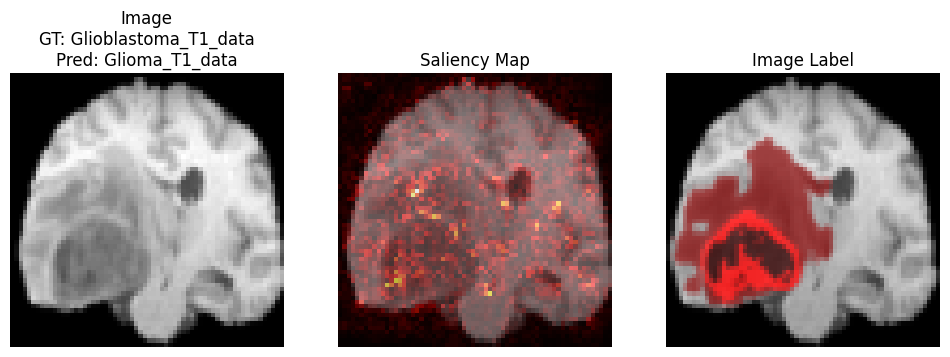

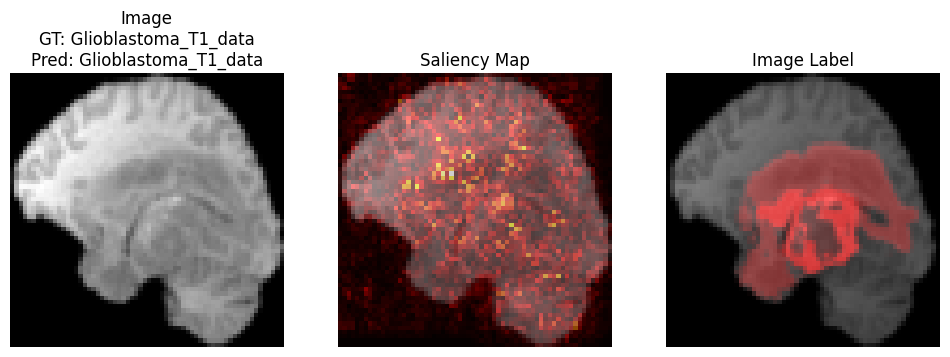

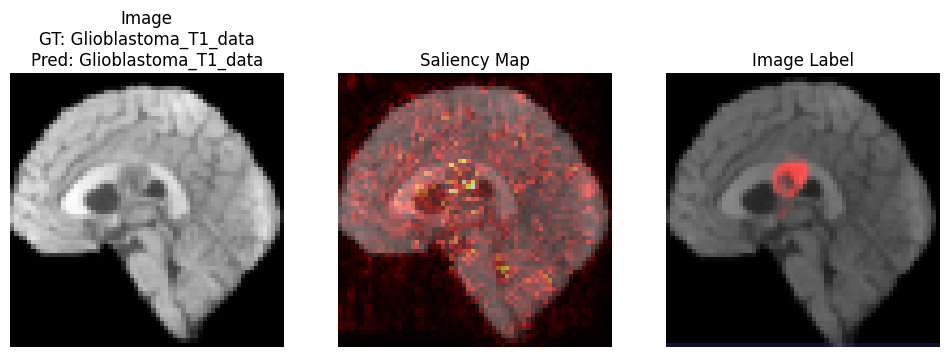

In [ ]:
visualize_saliency(
    highest_support_images_tensor,
    highest_support_labels,
    test_images_tensor,
    test_labels_tensor,  # Pass the tensor of labels only
    model,
    test_image_labels_tensor
)

In [ ]:
def visualize_integrated_gradients(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
    model
):
    model.eval()
    ig = IntegratedGradients(forward_fn)
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Compute predictions
    scores = model(support_images, support_labels, query_images)
    _, predicted_labels = torch.max(scores.data, 1)

    for i in range(len(query_labels)):
        query_image = query_images[i:i+1].clone()
        query_image.requires_grad_()
        gt_label = idx_to_class[query_labels[i].item()]
        pred_label = idx_to_class[predicted_labels[i].item()]

        # Compute integrated gradients
        attributions = ig.attribute(
            query_image,
            target=predicted_labels[i].item(),
            n_steps=50,
            additional_forward_args=(support_images, support_labels)
        )

        # Visualize the attributions
        attribution = attributions.squeeze().cpu().detach().numpy()
        attribution = np.abs(attribution).max(axis=0)
        attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)

        img_tensor = query_images[i].cpu()
        img = img_tensor.permute(1, 2, 0).numpy()
        img = np.float32(img)
        img = img / img.max()

        # Overlay the attributions on the image
        heatmap = plt.get_cmap('hot')(attribution)[:, :, :3]
        overlayed_img = heatmap * 0.5 + img * 0.5
        overlayed_img = overlayed_img / overlayed_img.max()

        # Plot the image and attributions
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img)
        axes[0].set_title(f"Image\nGT: {gt_label}\nPred: {pred_label}")
        axes[0].axis('off')

        axes[1].imshow(overlayed_img)
        axes[1].set_title("Integrated Gradients")
        axes[1].axis('off')
        plt.show()

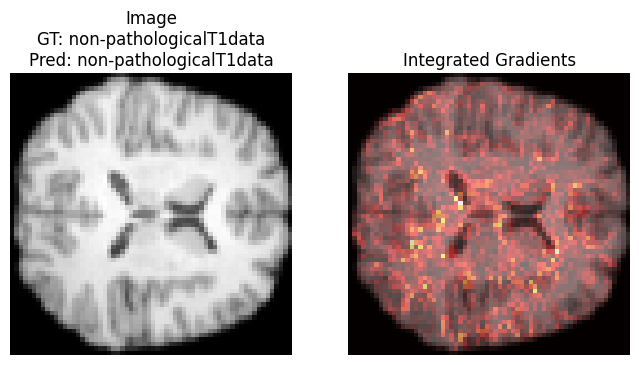

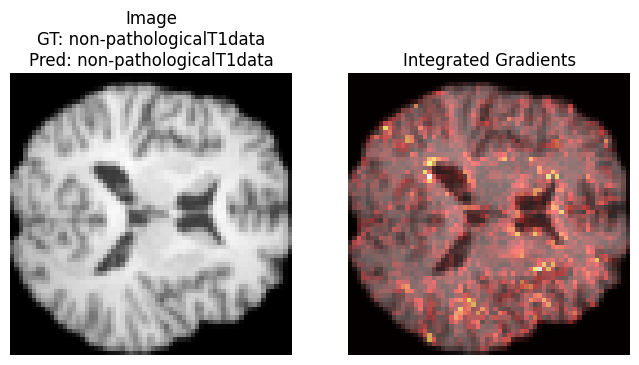

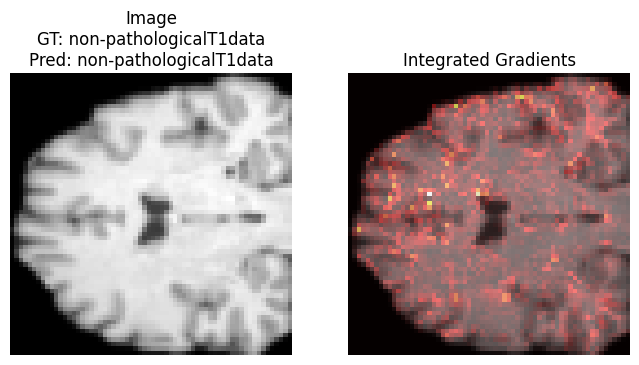

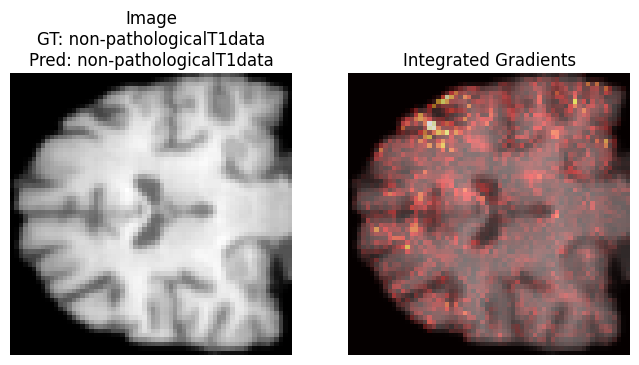

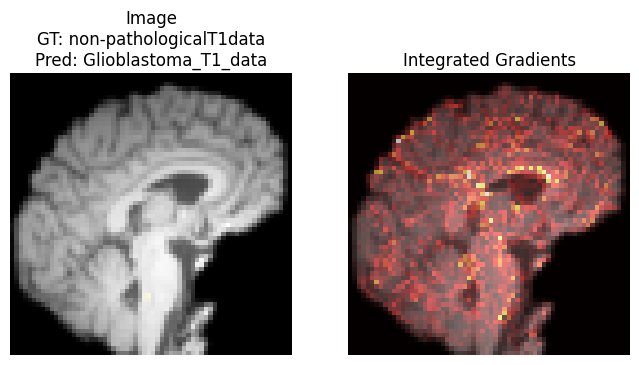

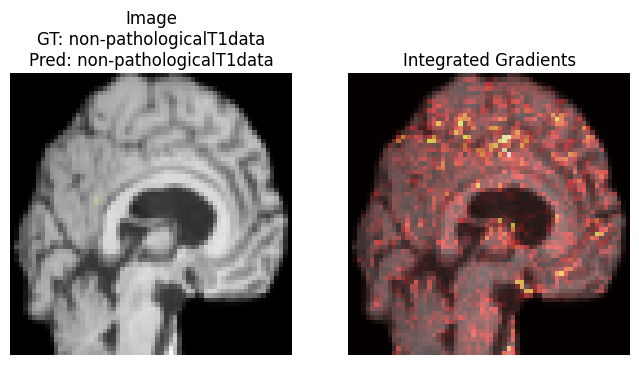

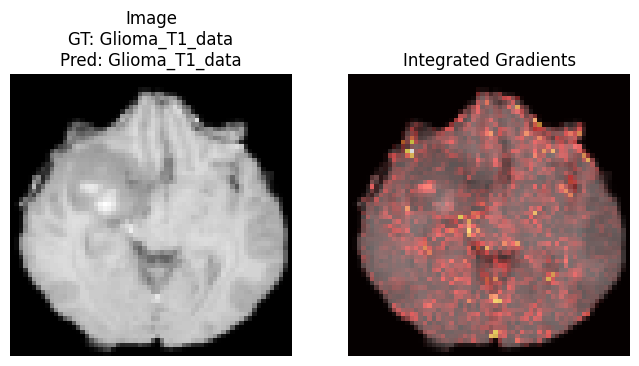

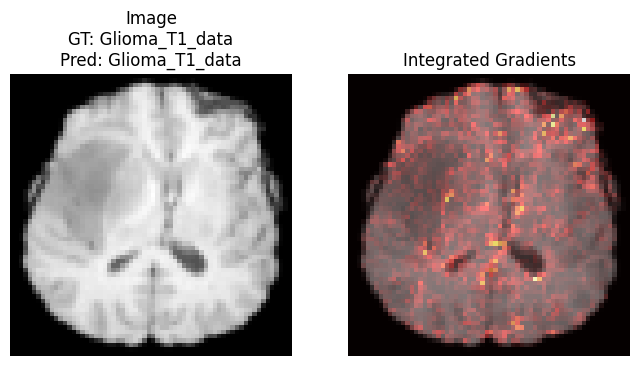

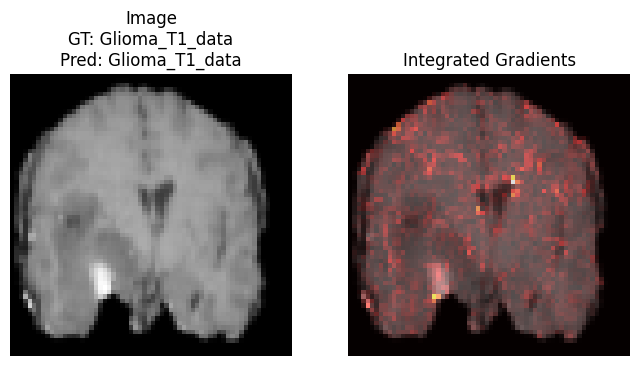

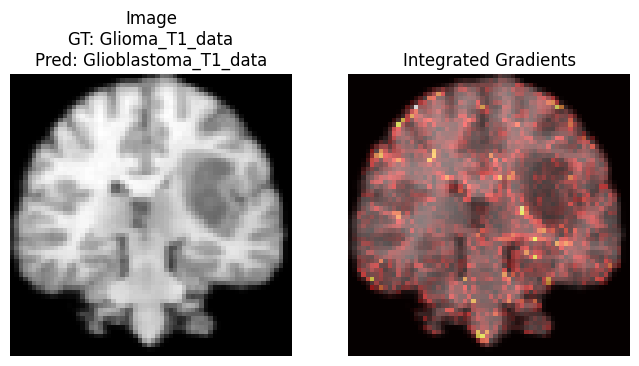

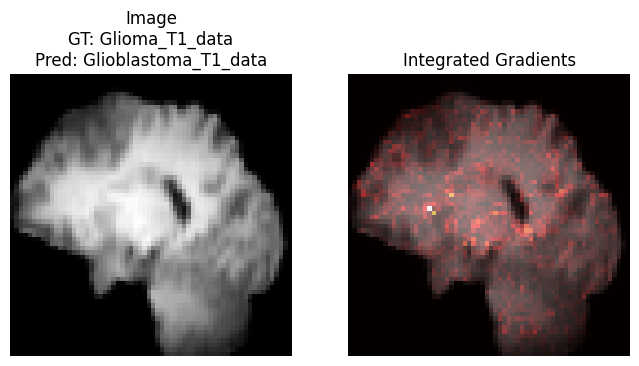

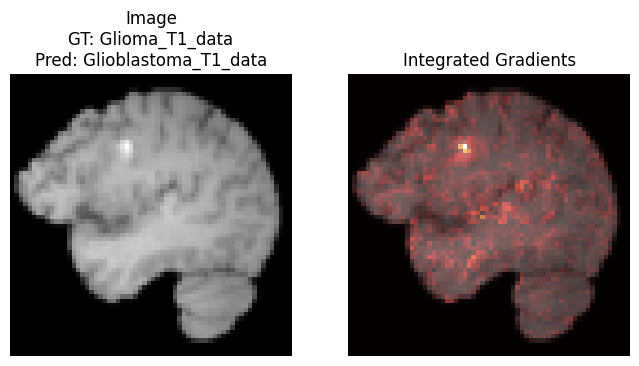

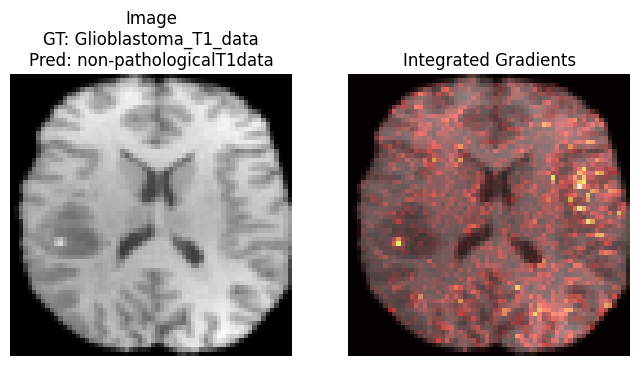

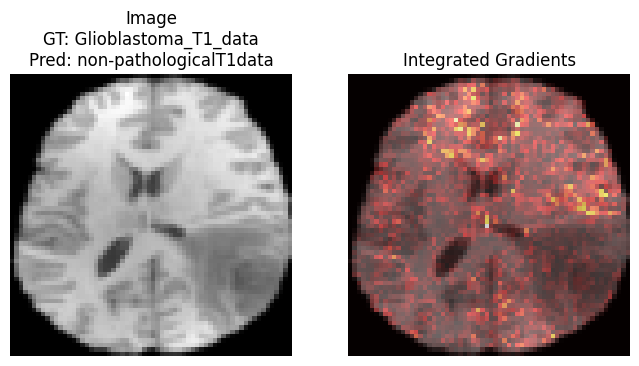

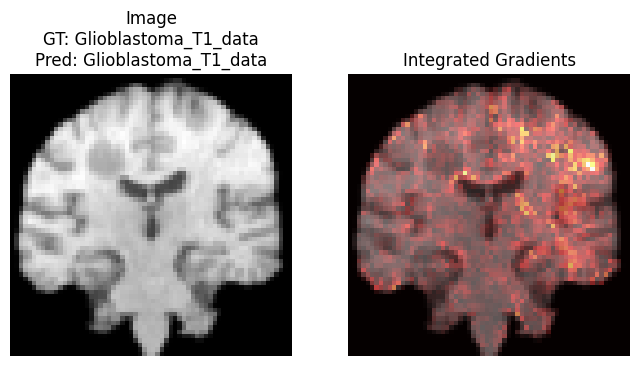

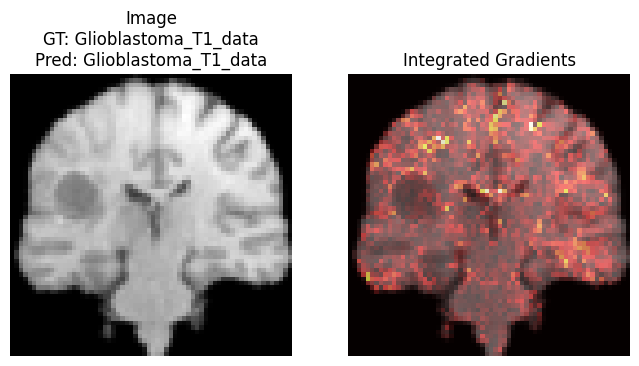

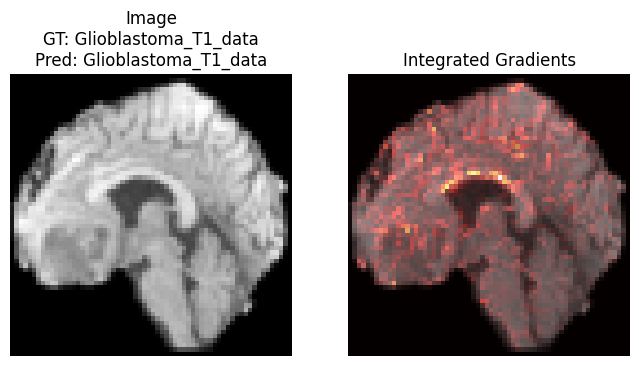

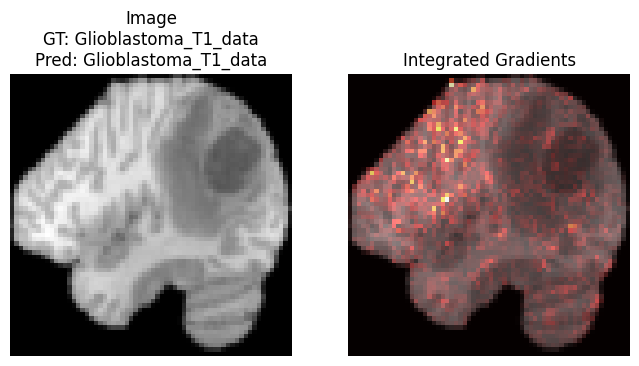

In [ ]:
visualize_integrated_gradients(
    highest_support_images_tensor,
    highest_support_labels,
    test_images_tensor,
    test_labels,
    model
)


Detailed Results:


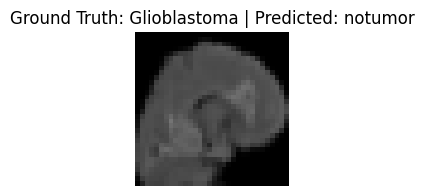

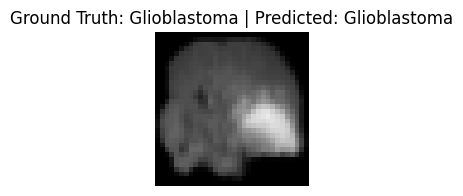

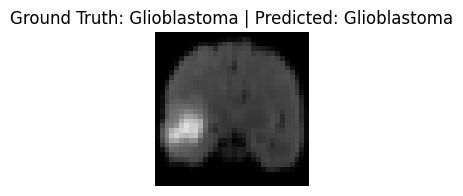

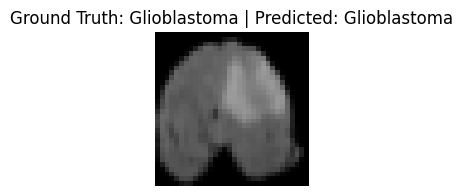

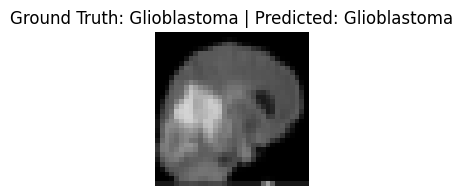

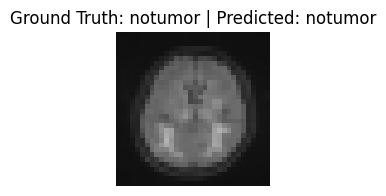

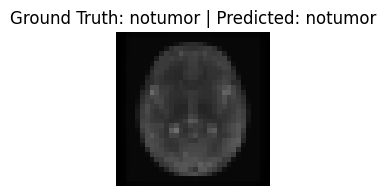

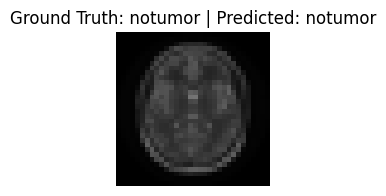

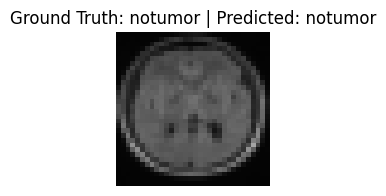

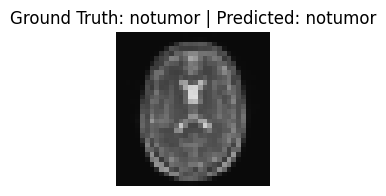


Accuracy: 9/10 = 90.00%
test performance for random:  9/10 =90.00%


In [ ]:
# random

random_support_images, query_images = sample_support_query(remaining_images, 5)
random_support_images_tensor, random_support_labels = process_images(random_support_images, transform, class_to_idx)
test_images_tensor, test_labels = process_images(test_images, transform, class_to_idx)
correct, total = evaluate(random_support_images_tensor, random_support_labels, test_images_tensor, test_labels, print_detailed=True)
print(f"test performance for random:  {correct}/{total} ={correct/total:.2%}")


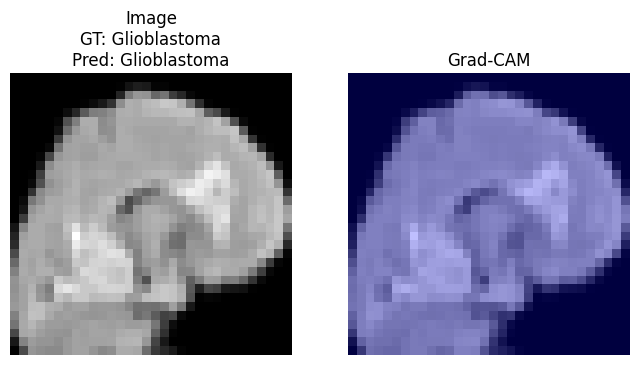

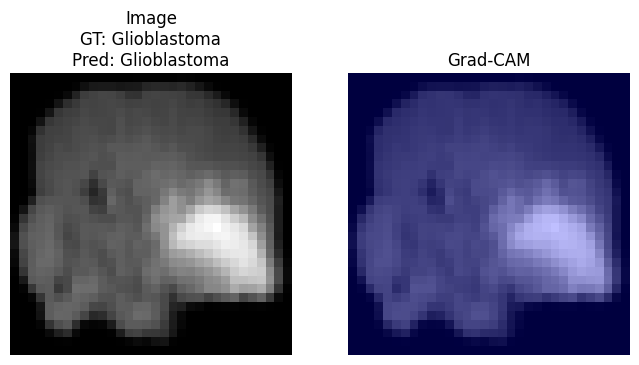

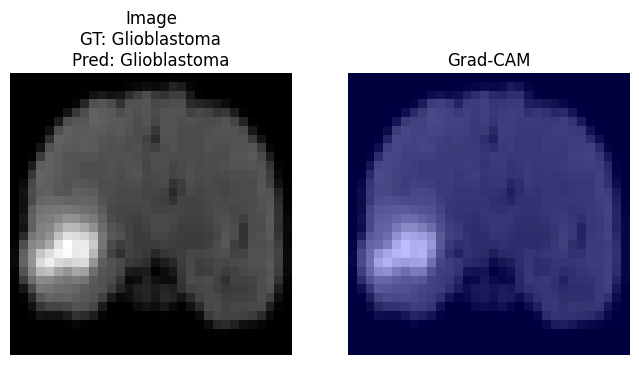

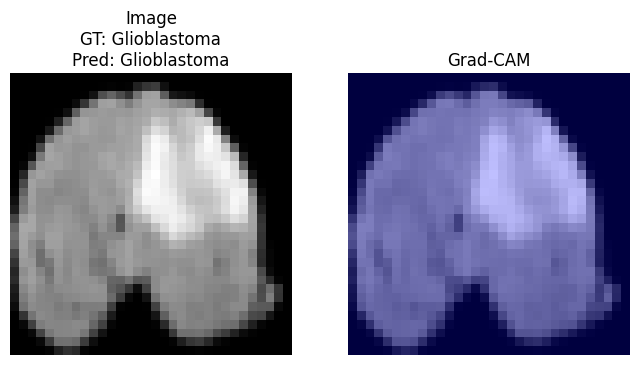

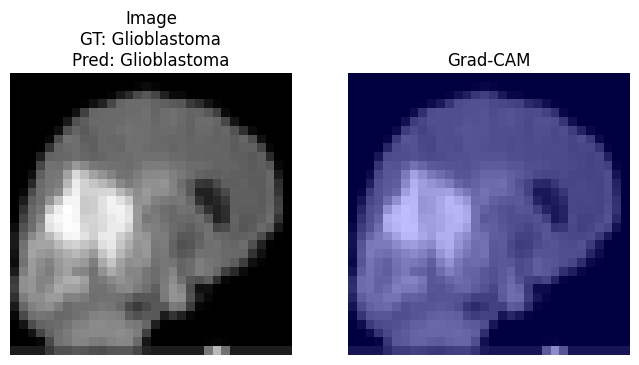

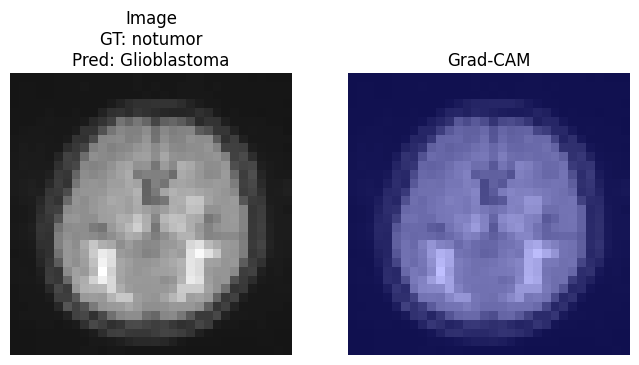

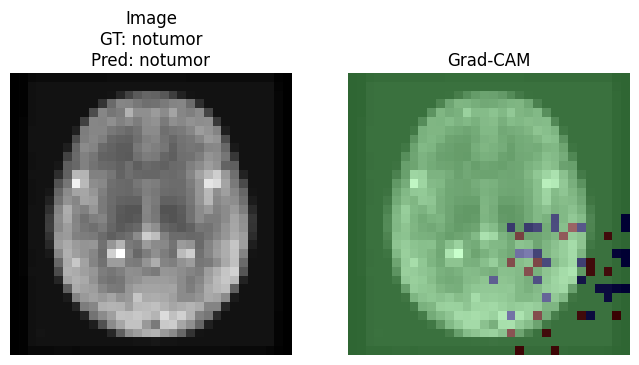

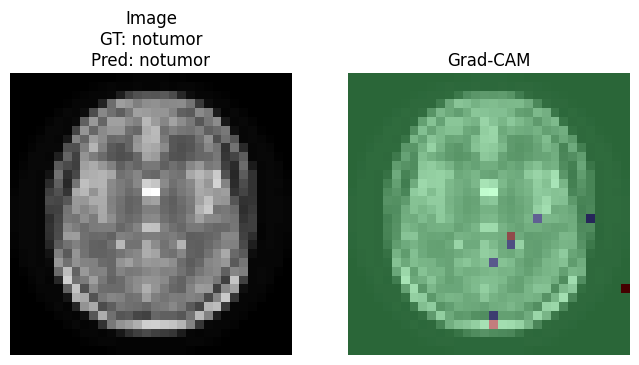

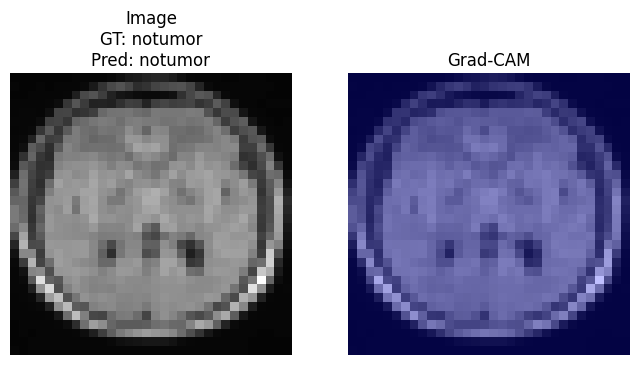

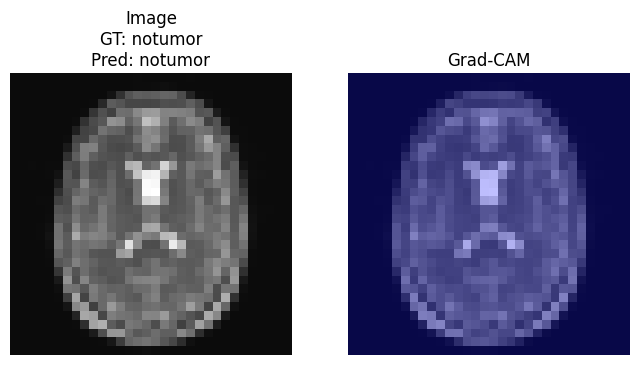


Accuracy: 9/10 = 90.00%
Test performance for random: 9/10 = 90.00%


In [ ]:
# Random
random_support_images, query_images = sample_support_query(remaining_images, 5)
random_support_images_tensor, random_support_labels = process_images(random_support_images, transform, class_to_idx)
correct, total = evaluate_new(
    random_support_images_tensor,
    random_support_labels,
    test_images_tensor,
    test_labels,
    print_detailed=True
)
print(f"Test performance for random: {correct}/{total} = {correct/total:.2%}")


Detailed Results:


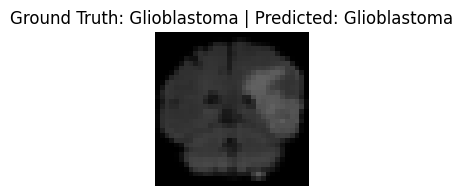

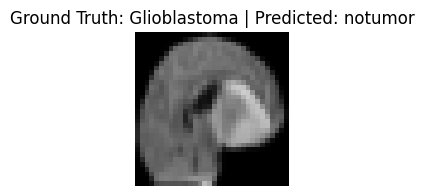

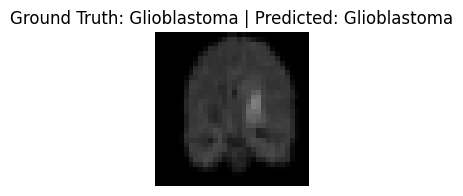

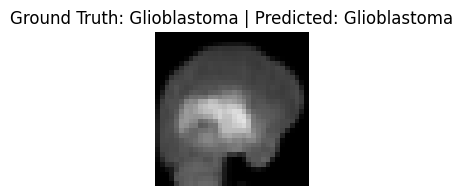

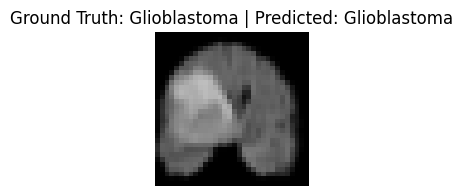

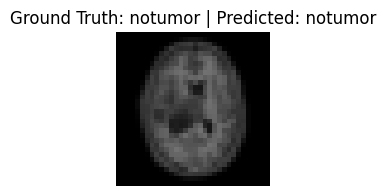

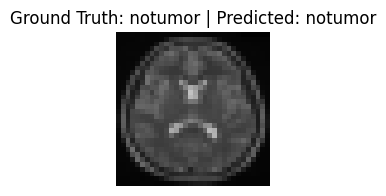

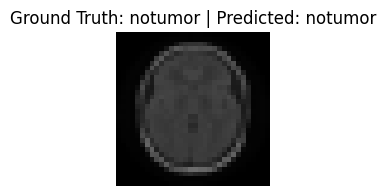

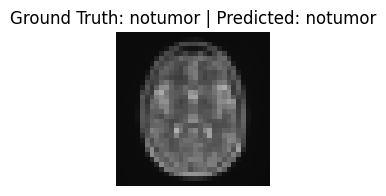

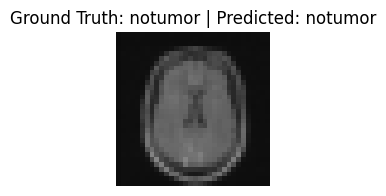


Accuracy: 9/10 = 90.00%
test performance for random:  9/10 =90.00%


In [ ]:
# all
remaining_images_tensor, query_images = sample_support_query(remaining_images, 30)

all_image_tensor, all_image_label = process_images(remaining_images_tensor, transform, class_to_idx)
test_images_tensor, test_labels = process_images(test_images, transform, class_to_idx)
correct, total = evaluate(all_image_tensor, all_image_label, test_images_tensor, test_labels, print_detailed=True)
print(f"test performance for random:  {correct}/{total} ={correct/total:.2%}")

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Calculate AUC

model.eval()
with torch.no_grad():
    # Get model scores on the test images
    scores = model(highest_support_images_tensor, highest_support_labels, test_images_tensor)
    print(scores.data)
    # Get the predicted labels from the model's scores
    _, predicted_labels = torch.max(scores.data, 1)
    # Convert scores and labels to numpy arrays
    scores_np = scores.detach().cpu().numpy()
    test_labels_np = test_labels.cpu().numpy()

    # Apply softmax to convert scores to probabilities
    # from scipy.special import softmax
    # scores_np = softmax(scores_np, axis=1)

    # Extract probabilities for the positive class (class 1)
    y_score = scores_np[:, 1]  # Shape: (n_samples,)

    # Ensure y_true is the correct shape
    y_true = test_labels_np  # Shape: (n_samples,)

    # Ensure test_labels_np is a 1D array
    print(f"y_true shape: {y_true.shape}")
    print(f"y_true contents:\n{y_true}")

    print(f"y_score shape: {y_score.shape}")
    print(f"y_score contents:\n{y_score}")

    auc = roc_auc_score(y_true, y_score)
    print(f"AUC: {auc:.4f}")


tensor([[-10.1494, -13.3771],
        [ -5.4948,  -9.3165],
        [ -6.6989,  -9.5711],
        [ -8.4715, -12.0566],
        [ -5.8655,  -7.2887],
        [ -7.6111,  -4.9026],
        [ -6.1720,  -4.8374],
        [ -6.7542,  -5.4411],
        [ -7.2226,  -6.7019],
        [ -8.4329,  -5.5852]])
y_true shape: (10,)
y_true contents:
[0 0 0 0 0 1 1 1 1 1]
y_score shape: (10,)
y_score contents:
[-13.377118   -9.316534   -9.571127  -12.056572   -7.2886534  -4.9026127
  -4.8373656  -5.4411416  -6.701917   -5.5851884]
AUC: 1.0000
